# Dubai Real Estate :: Forecasting and Evaluating Property Value
Develop data analytics reports & ML models to forecast/evaluate real estate property rental/selling prices. Gain insights from past transactions to set fair prices, make informed decisions & achieve successful outcomes for buyers & sellers.

### Luca Ordronneau

In [1]:
import numpy as np
import pandas as pd

import googlemaps

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score, train_test_split

import xgboost as xgb
import lightgbm as lgb

from scipy.special import inv_boxcox

pd.set_option('display.max_columns', None)

import plotly.io as pio
pio.templates.default = "seaborn"

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_rents = pd.read_csv("../data/rents.csv", sep=";", on_bad_lines='skip', engine="python")
df_transactions = pd.read_csv("../data/transactions.csv", sep=";", on_bad_lines='skip', engine="python")

# Data Cleaning + Feature engineering
Analyse missing and strange values, create some features for the analysis

In [3]:
df_rents["Contract Amount"] = df_rents["Contract Amount"].str.replace(',', '.').astype(float)
df_rents["Annual Amount"] = df_rents["Annual Amount"].str.replace(',', '.').astype(float)
df_rents["Property Size (sq.m)"] = df_rents["Property Size (sq.m)"].str.replace(',', '.').astype(float)

In [4]:
quantile_low = 0.01  # Specify the quantile
quantile_high = 0.99 

for col in ["Contract Amount", "Annual Amount", "Property Size (sq.m)"]:
    threshold_low = df_rents[col].quantile(quantile_low)
    threshold_high = df_rents[col].quantile(quantile_high)

    df_rents[col] = df_rents[col].apply(lambda x: np.nan if x < threshold_low else x)
    df_rents[col] = df_rents[col].apply(lambda x: np.nan if x > threshold_high else x)

for col in ["Transaction Size (sq.m)", "Property Size (sq.m)"]:
    threshold_low = df_transactions[col].quantile(quantile_low)
    threshold_high = df_transactions[col].quantile(quantile_high)
    
    df_transactions[col] = df_transactions[col].apply(lambda x: np.nan if x < threshold_low else x)
    df_transactions[col] = df_transactions[col].apply(lambda x: np.nan if x > threshold_high else x)

In [5]:
df_rents['Property Size (sq.m)'] = df_rents.groupby(['Property ID', 'Property Type', 'Property Sub Type'])['Property Size (sq.m)'].transform(lambda x: x.fillna(x.mean()))
df_rents['Number of Rooms'] = df_rents.groupby(['Property ID', 'Property Type', 'Property Sub Type'])['Number of Rooms'].transform(lambda x: x.fillna(x.mean()))

df_transactions['Transaction Size (sq.m)'] = df_transactions.groupby(['Property ID', 'Property Type', 'Property Sub Type'])['Transaction Size (sq.m)'].transform(lambda x: x.fillna(x.mean()))
df_transactions['Property Size (sq.m)'] = df_transactions.groupby(['Property ID', 'Property Type', 'Property Sub Type'])['Property Size (sq.m)'].transform(lambda x: x.fillna(x.mean()))

## Geocode address from *Area*, *Nearest Metro*, *Nearest Mall*, *Nearest Landmark* columns

In [6]:
def get_unique_places_geocode():
    df_rents_tmp = df_rents.copy(deep=True)
    df_rents_tmp = df_rents_tmp.fillna('temp_unique_string')
    df_transactions_tmp = df_transactions.copy(deep=True)
    df_transactions_tmp = df_transactions_tmp.fillna('temp_unique_string')
    
    unique_place_names = np.unique(np.concatenate((
        df_rents_tmp['Area'].unique(), df_rents_tmp['Nearest Metro'].unique(),
        df_rents_tmp['Nearest Mall'].unique(), df_rents_tmp['Nearest Landmark'].unique(),
        df_transactions_tmp['Area'].unique(), df_transactions_tmp['Nearest Metro'].unique(),
        df_transactions_tmp['Nearest Mall'].unique(), df_transactions_tmp['Nearest Landmark'].unique()
    )))
    
    gmaps = googlemaps.Client(key='<API_KEY>')
    place_corrdinates = {}
    for place in unique_place_names:
        # Geocoding an address
        geocode_result = gmaps.geocode(f'{place}, Dubaï')
        place_corrdinates[place] = geocode_result[0]["geometry"]['location']

    return place_corrdinates

In [7]:
place_corrdinates = {' B2-554': {'lat': 25.2048493, 'lng': 55.2707828},
 ' B2-555': {'lat': 25.2048493, 'lng': 55.2707828},
 ' B2-556': {'lat': 25.2048493, 'lng': 55.2707828},
 '1072': {'lat': 25.2048493, 'lng': 55.2707828},
 '1214': {'lat': 25.2048493, 'lng': 55.2707828},
 '3165': {'lat': 25.2048493, 'lng': 55.2707828},
 'ADCB Metro Station': {'lat': 25.2444766, 'lng': 55.2981938},
 'AKOYA OXYGEN': {'lat': 24.9902521, 'lng': 55.3784127},
 'AL BARARI': {'lat': 25.0994215, 'lng': 55.3129667},
 'AL FURJAN': {'lat': 25.0251668, 'lng': 55.1458611},
 'AL HABTOOR POLO': {'lat': 25.0807093, 'lng': 55.3687184},
 'AL KHAIL GATE': {'lat': 25.1374298, 'lng': 55.2601399},
 'AL KHAIL HEIGHTS': {'lat': 25.1583405, 'lng': 55.25451349999999},
 'AL WAHA': {'lat': 25.0292067, 'lng': 55.281921},
 'ARABIAN RANCHES I': {'lat': 25.0523684, 'lng': 55.2673602},
 'ARABIAN RANCHES II': {'lat': 25.0331427, 'lng': 55.272887},
 'ARABIAN RANCHES III': {'lat': 25.0600122, 'lng': 55.3138469},
 'ARABIAN RANCHES POLO CLUB': {'lat': 25.0523684, 'lng': 55.2673602},
 'ARJAN': {'lat': 25.0605347, 'lng': 55.2397317},
 'ASMARAN': {'lat': 25.2048493, 'lng': 55.2707828},
 'Abu Baker Al Siddique Metro Station': {'lat': 25.2708811, 'lng': 55.3328369},
 'Abu Hail': {'lat': 25.2858687, 'lng': 55.3281742},
 'Abu Hail Metro Station': {'lat': 25.2753319, 'lng': 55.3463734},
 'Airport Free Zone': {'lat': 25.2742212, 'lng': 55.3787424},
 'Airport Terminal 1 Metro Station': {'lat': 25.2484389, 'lng': 55.3523663},
 'Al Asbaq': {'lat': 25.2048493, 'lng': 55.2707828},
 'Al Aweer First': {'lat': 25.1784957, 'lng': 55.545002},
 'Al Aweer Second': {'lat': 25.1729666, 'lng': 55.5527764},
 'Al Bada': {'lat': 25.2247272, 'lng': 55.26874189999999},
 'Al Baharna': {'lat': 25.260373, 'lng': 55.292639},
 'Al Baraha': {'lat': 25.2819897, 'lng': 55.3184964},
 'Al Barsha': {'lat': 25.083827, 'lng': 55.220397},
 'Al Barsha First': {'lat': 25.1103799, 'lng': 55.1954315},
 'Al Barsha Second': {'lat': 25.1027774, 'lng': 55.2061506},
 'Al Barsha South Fifth': {'lat': 25.0764291, 'lng': 55.2314448},
 'Al Barsha South Fourth': {'lat': 25.0764291, 'lng': 55.2314448},
 'Al Barsha Third': {'lat': 25.083827, 'lng': 55.220397},
 'Al Barshaa South First': {'lat': 25.0764291, 'lng': 55.2314448},
 'Al Barshaa South Second': {'lat': 25.0764291, 'lng': 55.2314448},
 'Al Barshaa South Third': {'lat': 25.0764291, 'lng': 55.2314448},
 'Al Buteen': {'lat': 25.2580614, 'lng': 55.3233351},
 'Al Dhagaya': {'lat': 25.272632, 'lng': 55.3004654},
 'Al Eyas': {'lat': 25.2048493, 'lng': 55.2707828},
 "Al Faga'A": {'lat': 24.663015, 'lng': 55.184461},
 'Al Fahidi': {'lat': 25.2640103, 'lng': 55.28867210000001},
 'Al Fahidi Metro Station': {'lat': 25.2640103, 'lng': 55.28867210000001},
 'Al Garhoud': {'lat': 25.2436289, 'lng': 55.3474236},
 'Al Ghubaiba Metro Station': {'lat': 25.2649935, 'lng': 55.2891406},
 'Al Goze First': {'lat': 25.1738192, 'lng': 55.2446955},
 'Al Goze Fourth': {'lat': 25.1738192, 'lng': 55.2446955},
 'Al Goze Industrial First': {'lat': 25.2048493, 'lng': 55.2707828},
 'Al Goze Industrial Fourth': {'lat': 25.1738192, 'lng': 55.2446955},
 'Al Goze Industrial Second': {'lat': 25.1738192, 'lng': 55.2446955},
 'Al Goze Industrial Third': {'lat': 25.1738192, 'lng': 55.2446955},
 'Al Goze Second': {'lat': 25.1738192, 'lng': 55.2446955},
 'Al Goze Third': {'lat': 25.1738192, 'lng': 55.2446955},
 'Al Hamriya': {'lat': 25.2601903, 'lng': 55.3046728},
 'Al Hamriya Port': {'lat': 25.2993991, 'lng': 55.3346284},
 'Al Hebiah Fifth': {'lat': 25.0312024, 'lng': 55.2223492},
 'Al Hebiah First': {'lat': 25.0312024, 'lng': 55.2223492},
 'Al Hebiah Fourth': {'lat': 25.0312024, 'lng': 55.2223492},
 'Al Hebiah Second': {'lat': 25.0312024, 'lng': 55.2223492},
 'Al Hebiah Sixth': {'lat': 25.2048493, 'lng': 55.2707828},
 'Al Hebiah Third': {'lat': 25.2048493, 'lng': 55.2707828},
 'Al Hudaiba': {'lat': 25.2431974, 'lng': 55.2797959},
 'Al Jadaf': {'lat': 25.216757, 'lng': 55.3309395},
 'Al Jadaf Metro Station': {'lat': 25.2249568, 'lng': 55.3336402},
 'Al Jafiliya Metro Station': {'lat': 25.2336189, 'lng': 55.2921294},
 'Al Jafliya': {'lat': 25.2378401, 'lng': 55.2839416},
 'Al Karama': {'lat': 25.2489204, 'lng': 55.30605509999999},
 'Al Khabeesi': {'lat': 25.2666503, 'lng': 55.3337049},
 'Al Khairan  Second': {'lat': 25.1851339, 'lng': 55.3510778},
 'Al Khairan First': {'lat': 25.2048493, 'lng': 55.2707828},
 'Al Khawaneej': {'lat': 25.2327717, 'lng': 55.5081012},
 'Al Khawaneej First': {'lat': 25.2327717, 'lng': 55.5081012},
 'Al Khawaneej Second': {'lat': 25.2327717, 'lng': 55.5081012},
 'Al Kheeran': {'lat': 25.2171003, 'lng': 55.3613635},
 'Al Kifaf': {'lat': 25.2346972, 'lng': 55.2963797},
 'Al Lusaily': {'lat': 24.9337617, 'lng': 55.474856},
 'Al Maha': {'lat': 24.8239155, 'lng': 55.66107},
 'Al Makhtoum International Airport': {'lat': 24.8859505, 'lng': 55.1588019},
 'Al Mamzer': {'lat': 25.316746, 'lng': 55.3363372},
 'Al Manara': {'lat': 25.1410786, 'lng': 55.212112},
 'Al Mararr': {'lat': 25.2763663, 'lng': 55.3095542},
 'Al Marmoom': {'lat': 24.8029853, 'lng': 55.2489287},
 'Al Merkadh': {'lat': 25.2048493, 'lng': 55.2707828},
 'Al Mezhar': {'lat': 25.2491579, 'lng': 55.45269949999999},
 'Al Mezhar First': {'lat': 25.2491579, 'lng': 55.45269949999999},
 'Al Mezhar Second': {'lat': 25.2491579, 'lng': 55.45269949999999},
 'Al Murqabat': {'lat': 25.2653598, 'lng': 55.3240264},
 'Al Musalla (Dubai)': {'lat': 25.2741227, 'lng': 55.3061518},
 'Al Muteena': {'lat': 25.2740443, 'lng': 55.3226439},
 'Al Nahda First': {'lat': 25.2919567, 'lng': 55.365513},
 'Al Nahda Metro Station': {'lat': 25.2732961, 'lng': 55.3694559},
 'Al Nahda Second': {'lat': 25.2919567, 'lng': 55.365513},
 'Al Qiyadah Metro Station': {'lat': 25.2776265, 'lng': 55.3527146},
 'Al Qoaz': {'lat': 25.1514047, 'lng': 55.250782},
 'Al Qusais': {'lat': 25.2619867, 'lng': 55.3987166},
 'Al Qusais First': {'lat': 25.2534082, 'lng': 55.2928949},
 'Al Qusais Industrial Fifth': {'lat': 25.2880583, 'lng': 55.3945655},
 'Al Qusais Industrial First': {'lat': 25.2880583, 'lng': 55.3945655},
 'Al Qusais Industrial Fourth': {'lat': 25.2880583, 'lng': 55.3945655},
 'Al Qusais Industrial Second': {'lat': 25.2880583, 'lng': 55.3945655},
 'Al Qusais Industrial Third': {'lat': 25.2880583, 'lng': 55.3945655},
 'Al Qusais Metro Station': {'lat': 25.262714, 'lng': 55.3873658},
 'Al Qusais Second': {'lat': 25.2619867, 'lng': 55.3987166},
 'Al Qusais Third': {'lat': 25.2619867, 'lng': 55.3987166},
 'Al Raffa': {'lat': 25.255758, 'lng': 55.28808739999999},
 'Al Ras': {'lat': 25.2687811, 'lng': 55.2956887},
 'Al Ras Metro Station': {'lat': 25.2684763, 'lng': 55.2930125},
 'Al Rashidiya': {'lat': 25.2244647, 'lng': 55.38903089999999},
 'Al Rega': {'lat': 25.398149, 'lng': 55.5070991},
 'Al Rigga Metro Station': {'lat': 25.2633233, 'lng': 55.32385290000001},
 'Al Rowaiyah First': {'lat': 25.0870048, 'lng': 55.39698370000001},
 'Al Rowaiyah Second': {'lat': 25.0870048, 'lng': 55.39698370000001},
 'Al Rowaiyah Third': {'lat': 25.0870048, 'lng': 55.39698370000001},
 'Al Ruwayyah': {'lat': 25.0870048, 'lng': 55.39698370000001},
 'Al Sabkha': {'lat': 25.2711827, 'lng': 55.2998351},
 'Al Safaa': {'lat': 25.1586178, 'lng': 55.2245398},
 'Al Saffa First': {'lat': 25.1586178, 'lng': 55.2245398},
 'Al Saffa Second': {'lat': 25.1794821, 'lng': 55.2397317},
 'Al Safouh First': {'lat': 25.1133927, 'lng': 55.1762197},
 'Al Safouh Second': {'lat': 25.1081401, 'lng': 55.1651067},
 'Al Satwa': {'lat': 25.21937, 'lng': 55.272887},
 'Al Sufouh': {'lat': 25.1133927, 'lng': 55.1762197},
 'Al Suq Al Kabeer': {'lat': 25.262408, 'lng': 55.2936155},
 'Al Thanayah Fourth': {'lat': 25.0648629, 'lng': 55.1634109},
 'Al Thanyah Fifth': {'lat': 25.0709337, 'lng': 55.1552505},
 'Al Thanyah First': {'lat': 25.0983149, 'lng': 55.175287},
 'Al Thanyah Second': {'lat': 25.140104, 'lng': 55.2045914},
 'Al Thanyah Third': {'lat': 25.1352227, 'lng': 55.2122807},
 'Al Ttay': {'lat': 25.2355829, 'lng': 55.5532591},
 'Al Twar First': {'lat': 25.2620038, 'lng': 55.37934629999999},
 'Al Twar Second': {'lat': 25.2595109, 'lng': 55.3861357},
 'Al Twar Third': {'lat': 25.2620038, 'lng': 55.37934629999999},
 'Al Waheda': {'lat': 25.2897475, 'lng': 55.3378531},
 'Al Warqa First': {'lat': 25.1897737, 'lng': 55.4044135},
 'Al Warqa Fourth': {'lat': 25.1914848, 'lng': 55.43054859999999},
 'Al Warqa Second': {'lat': 25.1914848, 'lng': 55.43054859999999},
 'Al Warqa Third': {'lat': 25.1914848, 'lng': 55.43054859999999},
 'Al Warsan First': {'lat': 25.1599767, 'lng': 55.4246648},
 'Al Warsan Second': {'lat': 25.1479624, 'lng': 55.3888851},
 'Al Warsan Third': {'lat': 25.1479624, 'lng': 55.3888851},
 'Al Wasl': {'lat': 25.199425, 'lng': 55.25630770000001},
 'Al Yelayiss 1': {'lat': 25.2048493, 'lng': 55.2707828},
 'Al Yelayiss 2': {'lat': 25.2048493, 'lng': 55.2707828},
 'Al Yelayiss 3': {'lat': 25.2048493, 'lng': 55.2707828},
 'Al Yelayiss 4': {'lat': 25.2048493, 'lng': 55.2707828},
 'Al Yufrah 1': {'lat': 24.9822, 'lng': 55.4029},
 'Al Yufrah 2': {'lat': 24.963327, 'lng': 55.4068749},
 'Al Yufrah 3': {'lat': 24.963327, 'lng': 55.4068749},
 'Al Yufrah 4': {'lat': 24.963327, 'lng': 55.4068749},
 'Al-Aweer': {'lat': 25.1784957, 'lng': 55.545002},
 'Al-Baloosh': {'lat': 25.2145565, 'lng': 55.3032906},
 'Al-Bastakiyah': {'lat': 25.2642363, 'lng': 55.30026429999999},
 'Al-Cornich': {'lat': 25.2048493, 'lng': 55.2707828},
 'Al-Dzahiyyah Al-Jadeedah': {'lat': 25.2984331, 'lng': 55.36804369999999},
 'Al-Muhaisnah North': {'lat': 25.2048583, 'lng': 55.2707795},
 'Al-Murar Jadeed': {'lat': 25.2763552, 'lng': 55.3095108},
 'Al-Murar Qadeem': {'lat': 25.2763552, 'lng': 55.3095108},
 'Al-Musalla (Deira)': {'lat': 25.2741227, 'lng': 55.3061518},
 'Al-Mustashfa West': {'lat': 25.2048493, 'lng': 55.2707828},
 'Al-Nahdah': {'lat': 25.2919567, 'lng': 55.365513},
 'Al-Nakhal': {'lat': 25.2717156, 'lng': 55.311987},
 'Al-Qiyadah': {'lat': 25.2776458, 'lng': 55.3526907},
 'Al-Raulah': {'lat': 25.2048493, 'lng': 55.2707828},
 'Al-Riqqa East': {'lat': 25.2643465, 'lng': 55.3221723},
 'Al-Riqqa West': {'lat': 25.2643465, 'lng': 55.3221723},
 'Al-Safiyyah': {'lat': 25.2048493, 'lng': 55.2707828},
 'Al-Shumaal': {'lat': 25.2719745, 'lng': 55.2989082},
 'Al-Souq Al Kabeer (Deira)': {'lat': 25.262408, 'lng': 55.2936155},
 'Al-Tawar': {'lat': 25.2620038, 'lng': 55.37934629999999},
 'Al-Zarouniyyah': {'lat': 25.2048493, 'lng': 55.2707828},
 'BARSHA HEIGHTS': {'lat': 25.096962, 'lng': 55.1775999},
 'BLUEWATERS': {'lat': 25.0796205, 'lng': 55.1224096},
 'BURJ KHALIFA': {'lat': 25.197197, 'lng': 55.27437639999999},
 'BUSINESS BAY': {'lat': 25.1831647, 'lng': 55.272887},
 'BUSINESS PARK': {'lat': 25.2048493, 'lng': 55.2707828},
 'Baniyas Square Metro Station': {'lat': 25.2692711, 'lng': 55.3076239},
 'Buj Khalifa Dubai Mall Metro Station': {'lat': 25.2013981,
  'lng': 55.2694649},
 'Bukadra': {'lat': 25.1781358, 'lng': 55.3267916},
 'Bur Dubai': {'lat': 25.2145565, 'lng': 55.3032906},
 'Burj Al Arab': {'lat': 25.1411914, 'lng': 55.18524679999999},
 'Burj Khalifa': {'lat': 25.197197, 'lng': 55.27437639999999},
 'Burj Nahar': {'lat': 25.2727302, 'lng': 55.3162463},
 'Burjuman Metro Station': {'lat': 25.2547185, 'lng': 55.3042717},
 'Business Bay': {'lat': 25.1831647, 'lng': 55.272887},
 'Business Bay Metro Station': {'lat': 25.1912521, 'lng': 55.2603115},
 'CALIFORNIA RESIDENCE': {'lat': 25.0777153, 'lng': 55.3241166},
 'CHERRYWOODS': {'lat': 25.0086978, 'lng': 55.1593704},
 'CITY OF ARABIA': {'lat': 25.0840548, 'lng': 55.3281742},
 'CITY WALK': {'lat': 25.2074895, 'lng': 55.2625253},
 'City Centre Mirdif': {'lat': 25.216319, 'lng': 55.4077949},
 'Cornich Deira': {'lat': 25.2788468, 'lng': 55.3309395},
 'Creek Metro Station': {'lat': 25.2190685, 'lng': 55.33890969999999},
 'DAMAC HILLS': {'lat': 25.0292369, 'lng': 55.2527796},
 'DANUBE Metro Station': {'lat': 25.0014264, 'lng': 55.0955785},
 'DISCOVERY GARDENS': {'lat': 25.0390117, 'lng': 55.1444815},
 'DMCC-EZ2': {'lat': 25.2048493, 'lng': 55.2707828},
 'DOWN TOWN JABAL ALI': {'lat': 24.9764022, 'lng': 55.0908376},
 'DUBAI CREEK HARBOUR': {'lat': 25.1945448, 'lng': 55.3641298},
 'DUBAI DESIGN DISTRICT': {'lat': 25.1866742, 'lng': 55.3019726},
 'DUBAI GOLF CITY': {'lat': 25.0125131, 'lng': 55.234207},
 'DUBAI HARBOUR': {'lat': 25.0805422, 'lng': 55.1403426},
 'DUBAI HEALTHCARE CITY - PHASE 1': {'lat': 25.2317298, 'lng': 55.3240264},
 'DUBAI HEALTHCARE CITY - PHASE 2': {'lat': 25.2317298, 'lng': 55.3240264},
 'DUBAI HILLS': {'lat': 25.1002989, 'lng': 55.2458487},
 'DUBAI INDUSTRIAL CITY': {'lat': 24.8449335, 'lng': 55.0690393},
 'DUBAI INTERNATIONAL ACADEMIC CITY': {'lat': 25.113106, 'lng': 55.4084034},
 'DUBAI INVESTMENT PARK FIRST': {'lat': 24.9789814, 'lng': 55.1762197},
 'DUBAI INVESTMENT PARK SECOND': {'lat': 24.9789814, 'lng': 55.1762197},
 'DUBAI LAND RESIDENCE COMPLEX': {'lat': 25.0920511, 'lng': 55.38424029999999},
 'DUBAI LIFESTYLE CITY': {'lat': 25.0421807, 'lng': 55.2825597},
 'DUBAI MARINA': {'lat': 25.0805422, 'lng': 55.1403426},
 'DUBAI MARITIME CITY': {'lat': 25.2697914, 'lng': 55.2632154},
 'DUBAI OUTSOURCE CITY': {'lat': 25.1237489, 'lng': 55.4253578},
 'DUBAI PARKS': {'lat': 24.923946, 'lng': 55.0060946},
 'DUBAI PRODUCTION CITY': {'lat': 25.0317773, 'lng': 55.19002270000001},
 'DUBAI SCIENCE PARK': {'lat': 25.0745478, 'lng': 55.239559},
 'DUBAI SOUTH': {'lat': 24.8883012, 'lng': 55.1504392},
 'DUBAI SPORTS CITY': {'lat': 25.0391345, 'lng': 55.2176352},
 'DUBAI STUDIO CITY': {'lat': 25.0346728, 'lng': 55.2397317},
 'DUBAI WATER CANAL': {'lat': 25.1918143, 'lng': 55.2429717},
 'DUBAI WATER FRONT': {'lat': 24.955556, 'lng': 54.909444},
 'Damac Properties': {'lat': 25.2048493, 'lng': 55.2707828},
 'Deira City Centre': {'lat': 25.2519659, 'lng': 55.33280269999999},
 'Downtown Dubai': {'lat': 25.1949849, 'lng': 55.2784141},
 'Dubai Cycling Course': {'lat': 25.2048493, 'lng': 55.2707828},
 'Dubai International Airport': {'lat': 25.2531745, 'lng': 55.3656728},
 'Dubai Internet City': {'lat': 25.0976119, 'lng': 55.163109},
 'Dubai Investment Park First': {'lat': 24.9789814, 'lng': 55.1762197},
 'Dubai Investment Park Second': {'lat': 24.9789814, 'lng': 55.1762197},
 'Dubai Mall': {'lat': 25.1972295, 'lng': 55.279747},
 'Dubai Marina': {'lat': 25.0805422, 'lng': 55.1403426},
 'Dubai Parks and Resorts': {'lat': 24.923946, 'lng': 55.0060946},
 'EMAAR SOUTH': {'lat': 24.8691727, 'lng': 55.1373342},
 'EMIRATE LIVING': {'lat': 25.0455124, 'lng': 55.17345839999999},
 'ENERGY Metro Station': {'lat': 25.0263504, 'lng': 55.10126},
 'Emirates Metro Station': {'lat': 25.2410491, 'lng': 55.3656334},
 'Emirates Towers Metro Station': {'lat': 25.2173271, 'lng': 55.2799202},
 'Esalal': {'lat': 25.2048493, 'lng': 55.2707828},
 'Etisalat Metro Station': {'lat': 25.254796, 'lng': 55.4009325},
 'Expo 2020 Site': {'lat': 25.2048493, 'lng': 55.2707828},
 'Eyal Nasser': {'lat': 25.2728322, 'lng': 55.3037969},
 'FALCON CITY OF WONDERS': {'lat': 25.0999071, 'lng': 55.3420226},
 'Festival City First': {'lat': 25.2171003, 'lng': 55.3613635},
 'Financial Centre': {'lat': 25.2048493, 'lng': 55.2707828},
 'First Abu Dhabi Bank Metro Station': {'lat': 25.1284375, 'lng': 55.2108125},
 'GARDEN VIEW': {'lat': 25.0374025, 'lng': 55.1335032},
 'GGICO Metro Station': {'lat': 25.2494833, 'lng': 55.33996879999999},
 'GLOBAL VILLAGE': {'lat': 25.0717058, 'lng': 55.3085104},
 'GRAND HILLS DUBAI': {'lat': 25.2048493, 'lng': 55.2707828},
 'GRAND VIEWS': {'lat': 25.1444791, 'lng': 55.3018619},
 'Ghadeer Barashy': {'lat': 25.2048493, 'lng': 55.2707828},
 'Global Village': {'lat': 25.0717058, 'lng': 55.3085104},
 'Grayteesah': {'lat': 25.2048493, 'lng': 55.2707828},
 'HORIZON': {'lat': 25.1901317, 'lng': 55.2496862},
 'Hadaeq Sheikh Mohammed Bin Rashid': {'lat': 25.2048493, 'lng': 55.2707828},
 'Hamdan Sports Complex': {'lat': 25.0512308, 'lng': 55.3179763},
 'Harbour Tower': {'lat': 25.2622151, 'lng': 55.3148243},
 'Hatta': {'lat': 24.8061691, 'lng': 56.1253848},
 'Healthcare City Metro Station': {'lat': 25.2308904, 'lng': 55.3227935},
 'Hessyan First': {'lat': 25.2534082, 'lng': 55.2928949},
 'Hessyan Second': {'lat': 25.2048493, 'lng': 55.2707828},
 'Hor Al Anz': {'lat': 25.2769983, 'lng': 55.3337049},
 'Hor Al Anz East': {'lat': 25.2830909, 'lng': 55.351682},
 'IBN BATTUTA ': {'lat': 25.0457241, 'lng': 55.11815739999999},
 'IMG World Adventures': {'lat': 25.0823984, 'lng': 55.319675},
 'INTERNATIONAL CITY PH 1': {'lat': 25.1408551, 'lng': 55.4056356},
 'INTERNATIONAL CITY PH 2 & 3': {'lat': 25.1408551, 'lng': 55.4056356},
 'Ibn Battuta Metro Station': {'lat': 25.046352, 'lng': 55.11780899999999},
 'Ibn-e-Battuta Mall': {'lat': 25.0445472, 'lng': 55.1202972},
 'Island 2': {'lat': 25.2048493, 'lng': 55.2707828},
 'JABAL ALI STAFF ACCOMMODATION': {'lat': 24.9852264, 'lng': 55.1069702},
 'JABAL ALI VILLAGE': {'lat': 25.0292353, 'lng': 55.1320653},
 'JABEL ALI HILLS': {'lat': 24.9035625, 'lng': 54.9713125},
 'JADDAF WATERFRONT': {'lat': 25.2250683, 'lng': 55.3378531},
 'JUMEIRA BAY': {'lat': 25.2154004, 'lng': 55.2362787},
 'JUMEIRAH BEACH RESIDENCE': {'lat': 25.0769441, 'lng': 55.1341346},
 'JUMEIRAH GOLF': {'lat': 25.0192078, 'lng': 55.2010666},
 'JUMEIRAH HEIGHTS': {'lat': 25.0655904, 'lng': 55.14724080000001},
 'JUMEIRAH ISLANDS': {'lat': 25.058, 'lng': 55.15367999999999},
 'JUMEIRAH LAKES TOWERS': {'lat': 25.0692834, 'lng': 55.1417222},
 'JUMEIRAH LIVING': {'lat': 25.226808, 'lng': 55.28908500000001},
 'JUMEIRAH PARK': {'lat': 25.0471279, 'lng': 55.1555195},
 'JUMEIRAH VILLAGE CIRCLE': {'lat': 25.0601975, 'lng': 55.2093505},
 'JUMEIRAH VILLAGE TRIANGLE': {'lat': 25.0472882, 'lng': 55.19002270000001},
 'Jabal Ali': {'lat': 24.9857145, 'lng': 55.0272904},
 'Jabal Ali First': {'lat': 24.9857145, 'lng': 55.0272904},
 'Jabal Ali Industrial First': {'lat': 25.0019221, 'lng': 55.1265477},
 'Jabal Ali Industrial Second': {'lat': 25.0019221, 'lng': 55.1265477},
 'Jabal Ali Industrial Third': {'lat': 25.0019221, 'lng': 55.1265477},
 'Jabal Ali Second': {'lat': 24.9857145, 'lng': 55.0272904},
 'Jabal Ali Third': {'lat': 24.9857145, 'lng': 55.0272904},
 'Jabel Ali': {'lat': 24.9857145, 'lng': 55.0272904},
 'Jumeirah': {'lat': 25.2016428, 'lng': 55.2452567},
 'Jumeirah Beach Resdency': {'lat': 25.0769441, 'lng': 55.1341346},
 'Jumeirah Beach Residency': {'lat': 25.0769441, 'lng': 55.1341346},
 'Jumeirah First': {'lat': 25.2534082, 'lng': 55.2928949},
 'Jumeirah Lakes Towers': {'lat': 25.0692834, 'lng': 55.1417222},
 'Jumeirah Second': {'lat': 25.2016428, 'lng': 55.2452567},
 'Jumeirah Third': {'lat': 25.2016428, 'lng': 55.2452567},
 'Knowledge Village': {'lat': 25.1040726, 'lng': 55.163109},
 'LA MER': {'lat': 25.2048493, 'lng': 55.2707828},
 'LAYAN': {'lat': 25.025312, 'lng': 55.2808213},
 'LIVING LEGENDS': {'lat': 25.0910153, 'lng': 55.30260389999999},
 'LIWAN': {'lat': 25.1115263, 'lng': 55.3682795},
 'LIWAN 2': {'lat': 25.0976882, 'lng': 55.3599787},
 'Le Hemaira': {'lat': 25.2048493, 'lng': 55.2707828},
 'Lehbab': {'lat': 25.0421408, 'lng': 55.5912693},
 'Lehbab First': {'lat': 25.058895, 'lng': 55.586899},
 'Lehbab Second': {'lat': 25.0421408, 'lng': 55.5912693},
 'MADINAT JUMEIRAH': {'lat': 25.1330986, 'lng': 55.183466},
 'MAJAN': {'lat': 25.0914674, 'lng': 55.3171139},
 'MARSA AL ARAB': {'lat': 25.2591882, 'lng': 55.3099524},
 'MBR DISTRICT 1': {'lat': 25.1663758, 'lng': 55.2766574},
 'MBR DISTRICT 7': {'lat': 25.2048493, 'lng': 55.2707828},
 'MEDYAN GRANDSTAND': {'lat': 25.1595436, 'lng': 55.3031987},
 'MEDYAN RACE COURSE VILLAS': {'lat': 25.1573583, 'lng': 55.3014904},
 'MEYDAN AVENUE': {'lat': 25.1573583, 'lng': 55.3014904},
 'MEYDAN HEIGHTS': {'lat': 25.1427057, 'lng': 55.3151476},
 'MEYDAN ONE': {'lat': 25.1799889, 'lng': 55.2977123},
 'MILLENNIUM': {'lat': 25.1013345, 'lng': 55.177584},
 'MINA RASHID': {'lat': 25.284755, 'lng': 55.2756505},
 'MIRA': {'lat': 25.0589782, 'lng': 55.2957196},
 'MOTOR CITY': {'lat': 25.0450177, 'lng': 55.2397317},
 'MUDON': {'lat': 25.0234353, 'lng': 55.2716551},
 'Madinat Al Mataar': {'lat': 25.2048493, 'lng': 55.2707828},
 'Madinat Dubai Almelaheyah': {'lat': 25.1330986, 'lng': 55.183466},
 'Mall of the Emirates': {'lat': 25.118107, 'lng': 55.200608},
 'Mankhool': {'lat': 25.2459667, 'lng': 55.29499759999999},
 'Margham': {'lat': 24.9037042, 'lng': 55.6273332},
 'Marina Mall': {'lat': 25.07643, 'lng': 55.140504},
 'Marina Mall Metro Station': {'lat': 25.07643, 'lng': 55.140504},
 'Marina Towers': {'lat': 25.0866657, 'lng': 55.150092},
 'Marsa Dubai': {'lat': 25.0805422, 'lng': 55.1403426},
 "Me'Aisem First": {'lat': 25.0403412, 'lng': 55.19681569999999},
 'Media City': {'lat': 25.0961362, 'lng': 55.1575893},
 'Mena Jabal Ali': {'lat': 24.984977, 'lng': 55.04382520000001},
 'Mina Seyahi': {'lat': 25.2048493, 'lng': 55.2707828},
 'Mirdif': {'lat': 25.2196159, 'lng': 55.41947529999999},
 'Motor City': {'lat': 25.0450177, 'lng': 55.2397317},
 'Muashrah Al Bahraana': {'lat': 25.2048493, 'lng': 55.2707828},
 'Mugatrah': {'lat': 25.2048493, 'lng': 55.2707828},
 'Muhaisanah Fifth': {'lat': 25.2712259, 'lng': 55.4042518},
 'Muhaisanah First': {'lat': 25.2534082, 'lng': 55.2928949},
 'Muhaisanah Fourth': {'lat': 25.2712259, 'lng': 55.4042518},
 'Muhaisanah Second': {'lat': 25.27566, 'lng': 55.429581},
 'Muhaisanah Third': {'lat': 25.26104, 'lng': 55.41947529999999},
 'Muhaisna': {'lat': 25.2712259, 'lng': 55.4042518},
 'Muragab': {'lat': 25.2048493, 'lng': 55.2707828},
 'Mushrif': {'lat': 25.2077215, 'lng': 55.45269949999999},
 'NAD AL SHEBA GARDENS': {'lat': 25.1487596, 'lng': 55.3574208},
 'NUZUL': {'lat': 25.0015382, 'lng': 55.1053301},
 'Nad Al Hamar': {'lat': 25.2004324, 'lng': 55.3862638},
 'Nad Al Shiba': {'lat': 25.1487596, 'lng': 55.3574208},
 'Nad Al Shiba First': {'lat': 25.1435458, 'lng': 55.3475331},
 'Nad Al Shiba Fourth': {'lat': 25.141959, 'lng': 55.3135209},
 'Nad Al Shiba Second': {'lat': 25.1435458, 'lng': 55.3475331},
 'Nad Al Shiba Third': {'lat': 25.1414976, 'lng': 55.3108594},
 'Nad Rashid': {'lat': 25.2788708, 'lng': 55.3937684},
 'Nad Shamma': {'lat': 25.2168894, 'lng': 55.3848803},
 'Nadd Hessa': {'lat': 25.2048493, 'lng': 55.2707828},
 'Naif': {'lat': 25.2727524, 'lng': 55.3129667},
 'Naif North': {'lat': 25.2744537, 'lng': 55.308914},
 'Naif South': {'lat': 25.2744537, 'lng': 55.308914},
 'Nakheel Metro Station': {'lat': 25.0888349, 'lng': 55.1580819},
 'Nazwah': {'lat': 25.2048493, 'lng': 55.2707828},
 'Noor Bank Metro Station': {'lat': 25.1557678, 'lng': 55.2285226},
 'Oud Al Muteena First': {'lat': 25.2665492, 'lng': 55.4499303},
 'Oud Al Muteena Second': {'lat': 25.2665492, 'lng': 55.4499303},
 'Oud Almuteena Third': {'lat': 25.2665492, 'lng': 55.4499303},
 'Oud Metha': {'lat': 25.239126, 'lng': 55.3129667},
 'Oud Metha Metro Station': {'lat': 25.239126, 'lng': 55.3129667},
 'PALM DEIRA': {'lat': 25.333333, 'lng': 55.26805599999999},
 'PALM JABAL ALI': {'lat': 25.0072733, 'lng': 54.98734469999999},
 'PALM JUMEIRAH': {'lat': 25.1124317, 'lng': 55.13897799999999},
 'PALMAROSA': {'lat': 25.2048493, 'lng': 55.2707828},
 'PEARL JUMEIRA': {'lat': 25.245043, 'lng': 55.25768919999999},
 'POLO TOWNHOUSES IGO': {'lat': 25.1427455, 'lng': 55.2945394},
 'Palm Deira': {'lat': 25.333333, 'lng': 55.26805599999999},
 'Palm Deira Metro Stations': {'lat': 25.2757352, 'lng': 55.3012094},
 'Palm Jabal Ali': {'lat': 25.0072733, 'lng': 54.98734469999999},
 'Palm Jumeirah': {'lat': 25.1124317, 'lng': 55.13897799999999},
 'Port Saeed': {'lat': 25.2513145, 'lng': 55.3295568},
 'REMRAAM': {'lat': 25.0042305, 'lng': 55.2514865},
 'RUKAN': {'lat': 25.133535, 'lng': 55.18570099999999},
 'Ras Al Khor': {'lat': 25.1945448, 'lng': 55.3641298},
 'Ras Al Khor Industrial First': {'lat': 25.1801556, 'lng': 55.3392359},
 'Ras Al Khor Industrial Second': {'lat': 25.1801556, 'lng': 55.3392359},
 'Ras Al Khor Industrial Third': {'lat': 25.1801556, 'lng': 55.3392359},
 'Rashidiya Metro Station': {'lat': 25.229336, 'lng': 55.3911661},
 'Rega Al Buteen': {'lat': 25.2580614, 'lng': 55.3233351},
 'SAMA AL JADAF': {'lat': 25.216757, 'lng': 55.3309395},
 'SERENA': {'lat': 25.0380149, 'lng': 55.2880116},
 'SILICON OASIS': {'lat': 25.1279484, 'lng': 55.3862638},
 'SOBHA HEARTLAND': {'lat': 25.1756117, 'lng': 55.3073293},
 'STADIUM Metro Station': {'lat': 25.2778125, 'lng': 55.3614375},
 'SUFOUH GARDENS': {'lat': 25.1103251, 'lng': 55.1780541},
 'SUSTAINABLE CITY': {'lat': 25.0277766, 'lng': 55.27703229999999},
 'Saih Aldahal': {'lat': 24.7552963, 'lng': 55.3643098},
 'Saih Shuaib 1': {'lat': 24.8975106, 'lng': 54.9898029},
 'Saih Shuaib 2': {'lat': 24.8975106, 'lng': 54.9898029},
 'Saih Shuaib 3': {'lat': 24.8975106, 'lng': 54.9898029},
 'Saih Shuaib 4': {'lat': 24.8975106, 'lng': 54.9898029},
 'Salah Al Din Metro Station': {'lat': 25.2701408, 'lng': 55.3209295},
 'Shandagha': {'lat': 25.2670274, 'lng': 55.2893391},
 'Shandagha East': {'lat': 25.2670274, 'lng': 55.2893391},
 'Shandagha West': {'lat': 25.2670274, 'lng': 55.2893391},
 'Sharaf Dg Metro Station': {'lat': 25.2582422, 'lng': 55.2975467},
 'Sikkat Al Khail North': {'lat': 25.1374298, 'lng': 55.2601399},
 'Sikkat Al Khail South': {'lat': 25.1374298, 'lng': 55.2601399},
 'Sports City Swimming Academy': {'lat': 25.0391345, 'lng': 55.2176352},
 'TECOM SITE A': {'lat': 25.096962, 'lng': 55.1775999},
 'TECOM SITE D': {'lat': 25.096962, 'lng': 55.1775999},
 'THE BEACH': {'lat': 25.0754093, 'lng': 55.1313156},
 'THE ECHO PLEX CITY': {'lat': 25.2048493, 'lng': 55.2707828},
 'THE FIELD': {'lat': 25.1225359, 'lng': 55.3424969},
 'THE GARDENS': {'lat': 25.0423411, 'lng': 55.127927},
 'THE GREENS': {'lat': 25.0920718, 'lng': 55.1713892},
 'THE LAKES': {'lat': 25.0792423, 'lng': 55.1693191},
 'THE VALLEY': {'lat': 25.2048493, 'lng': 55.2707828},
 'THE VILLA': {'lat': 25.0876881, 'lng': 55.3613635},
 'THE WORLD': {'lat': 25.22782878652507, 'lng': 55.16519345580009},
 'TIJARA TOWN': {'lat': 25.0431286, 'lng': 55.4277802},
 'TILAL AL GHAF': {'lat': 25.0244087, 'lng': 55.2282872},
 'TOWN SQUARE': {'lat': 25.0002811, 'lng': 55.2922053},
 'Tawaa Al Sayegh': {'lat': 25.2048493, 'lng': 55.2707828},
 'Tawi Al Muraqqab': {'lat': 25.2653598, 'lng': 55.3240264},
 'Terminal 3 ': {'lat': 25.2484205, 'lng': 55.36119610000001},
 'Trade Center First': {'lat': 25.2190916, 'lng': 55.27910499999999},
 'Trade Center Second': {'lat': 25.2223231, 'lng': 55.2839416},
 'Trade Centre Metro Station': {'lat': 25.2248235, 'lng': 55.2850306},
 'UAE Exchange Metro Station': {'lat': 24.9775135, 'lng': 55.0909993},
 'Um Al Sheif': {'lat': 25.1327715, 'lng': 55.2052085},
 'Um Esalay': {'lat': 25.2048493, 'lng': 55.2707828},
 'Um Hurair First': {'lat': 25.2534082, 'lng': 55.2928949},
 'Um Hurair Second': {'lat': 25.2378284, 'lng': 55.3226439},
 'Um Nahad First': {'lat': 25.0334172, 'lng': 55.422677},
 'Um Nahad Second': {'lat': 25.2048493, 'lng': 55.2707828},
 'Um Nahad Third': {'lat': 25.2048493, 'lng': 55.2707828},
 'Um Ramool': {'lat': 25.2289254, 'lng': 55.3668963},
 'Um Suqaim': {'lat': 25.1551127, 'lng': 55.2065891},
 'Um Suqaim First': {'lat': 25.1551127, 'lng': 55.2065891},
 'Um Suqaim Second': {'lat': 25.1551127, 'lng': 55.2065891},
 'Um Suqaim Third': {'lat': 25.1551127, 'lng': 55.2065891},
 'Umm Addamin': {'lat': 25.2048493, 'lng': 55.2707828},
 'Union Metro Station': {'lat': 25.2663361, 'lng': 55.31450539999999},
 'VILLANOVA': {'lat': 25.0729344, 'lng': 55.3587368},
 'Wadi Al Amardi': {'lat': 25.1995236, 'lng': 55.480396},
 'Wadi Al Safa 2': {'lat': 25.1115263, 'lng': 55.3682795},
 'Wadi Al Safa 3': {'lat': 25.1061936, 'lng': 55.3202046},
 'Wadi Al Safa 4': {'lat': 25.0817675, 'lng': 55.3258081},
 'Wadi Al Safa 5': {'lat': 25.0939009, 'lng': 55.3827294},
 'Wadi Al Safa 6': {'lat': 25.0939009, 'lng': 55.3827294},
 'Wadi Al Safa 7': {'lat': 25.0442392, 'lng': 55.2897019},
 'Wadi Alshabak': {'lat': 25.1685007, 'lng': 55.4914865},
 'Warsan First': {'lat': 25.1599767, 'lng': 55.4246648},
 'Warsan Fourth': {'lat': 25.1633458, 'lng': 55.4416234},
 'World Islands': {'lat': 25.22782878652507, 'lng': 55.16519345580009},
 'Yaraah': {'lat': 24.7304123, 'lng': 55.62014689999999},
 'Zaabeel First': {'lat': 25.2174599, 'lng': 55.3031542},
 'Zaabeel Second': {'lat': 25.2230543, 'lng': 55.30605509999999},
 'Zareeba Duviya': {'lat': 25.2048493, 'lng': 55.2707828}}

In [8]:
df_rents[['Area Geocode', 'Nearest Metro Geocode', 'Nearest Mall Geocode', 'Nearest Landmark Geocode']] = df_rents.loc[:, ['Area', 'Nearest Metro', 'Nearest Mall', 'Nearest Landmark']]
df_transactions[['Area Geocode', 'Nearest Metro Geocode', 'Nearest Mall Geocode', 'Nearest Landmark Geocode']] = df_transactions.loc[:, ['Area', 'Nearest Metro', 'Nearest Mall', 'Nearest Landmark']]

In [9]:
for col in ['Area Geocode', 'Nearest Metro Geocode', 'Nearest Mall Geocode', 'Nearest Landmark Geocode']:
    df_rents[col] = df_rents[col].map(place_corrdinates)
    df_transactions[col] = df_transactions[col].map(place_corrdinates)

In [10]:
columns = ['Area Geocode', 'Nearest Metro Geocode', 'Nearest Mall Geocode', 'Nearest Landmark Geocode']

for col in columns:
    col_feature = col.lower().replace(' ', '_')
    df_rents[f'feature_{col_feature}_lat'] = df_rents[col].apply(lambda x: x.get('lat', None) if isinstance(x, dict) else None)
    df_rents[f'feature_{col_feature}_lng'] = df_rents[col].apply(lambda x: x.get('lng', None) if isinstance(x, dict) else None)
    df_transactions[f'feature_{col_feature}_lat'] = df_transactions[col].apply(lambda x: x.get('lat', None) if isinstance(x, dict) else None)
    df_transactions[f'feature_{col_feature}_lng'] = df_transactions[col].apply(lambda x: x.get('lng', None) if isinstance(x, dict) else None)

In [11]:
def convert_to_datetime(df, column_name):
    df[column_name] = pd.to_datetime(df[column_name], format="%d/%m/%Y %H:%M:%S", errors='coerce')
    return df

df_rents = convert_to_datetime(df_rents, "Registration Date")
df_rents = convert_to_datetime(df_rents, "Start Date")
df_rents = convert_to_datetime(df_rents, "End Date")

df_transactions["Transaction Date"] = pd.to_datetime(df_transactions["Transaction Date"], errors='coerce')

# Data Analysis

## 1. Global Analysis
### Rents

In [12]:
df_rents["Rent Time"] = df_rents["End Date"] - df_rents["Start Date"]

In [13]:
def rents_group_by_freq(df, key, freq):
    return df.groupby([pd.Grouper(key=key, freq=freq)], as_index=False).agg({'Ejari Contract Number':'count', 'Rent Time':'mean', 'Contract Amount':'mean', 'Annual Amount':'mean'})

df_rents_weekly = rents_group_by_freq(df_rents, key="Registration Date", freq="W")
df_rents_monthly = rents_group_by_freq(df_rents, key="Registration Date", freq="M")
df_rents_yearly = rents_group_by_freq(df_rents, key="Registration Date", freq="Y")

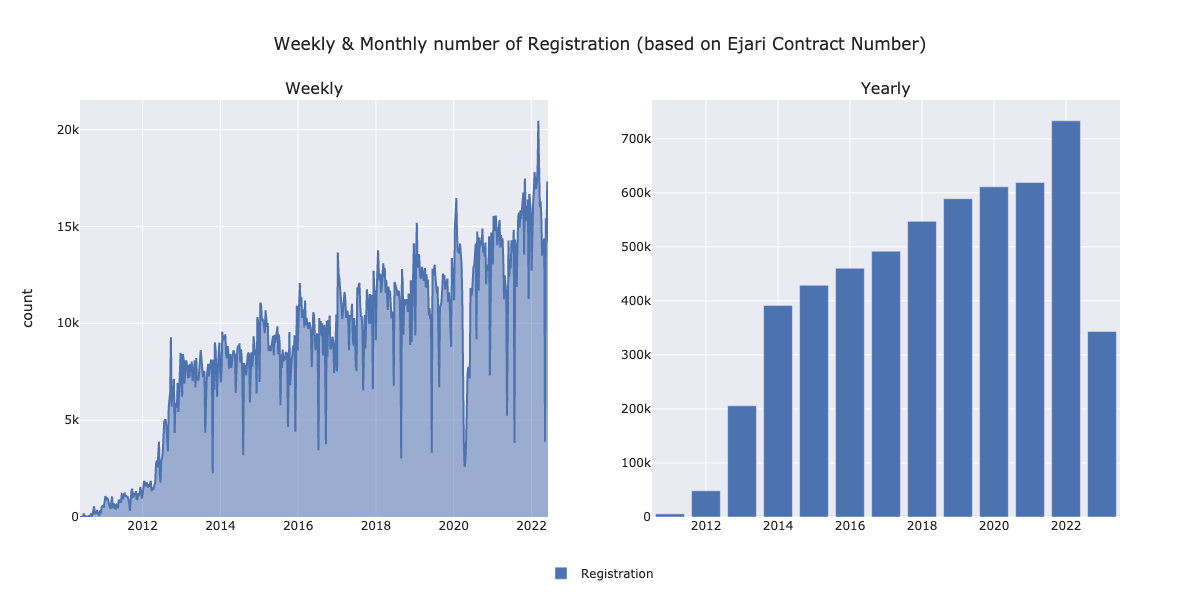

In [14]:
color = pio.templates[pio.templates.default].layout.colorway[0]
 
fig = make_subplots(
    subplot_titles=["Weekly", "Yearly"],
    rows=1, cols=2,
    shared_xaxes=True
)

fig.add_trace(go.Scatter(name="Registration", x=df_rents_weekly["Registration Date"], y=df_rents_weekly["Ejari Contract Number"], fill='tozeroy', marker=dict(color=color), showlegend=False), row=1, col=1)
fig.add_trace(go.Bar(name="Registration", x=df_rents_yearly["Registration Date"], y=df_rents_yearly["Ejari Contract Number"], marker=dict(color=color)), row=1, col=2)

fig.update_yaxes(title_text='count', col=1)
fig.update_layout(title={'text':'Weekly & Monthly number of Registration (based on Ejari Contract Number)'})
fig.update_layout(legend = dict(orientation = 'h', xanchor = "center", x = 0.5, y= -0.1))
fig.update_layout(width=1200, height=600)
fig.show("png")

In [15]:
def column_value_counts(df, column_name):
    
    value_counts = df[column_name].value_counts()
    df_value_counts = pd.DataFrame(value_counts)
    df_value_counts = df_value_counts.reset_index()

    return df_value_counts

In [16]:
df_pt_value_counts = column_value_counts(df_rents, 'Property Type')
df_pt_value_counts_ot = df_rents.groupby(['Property Type', pd.Grouper(key="Registration Date", freq="Y")]).size().reset_index(name='count')

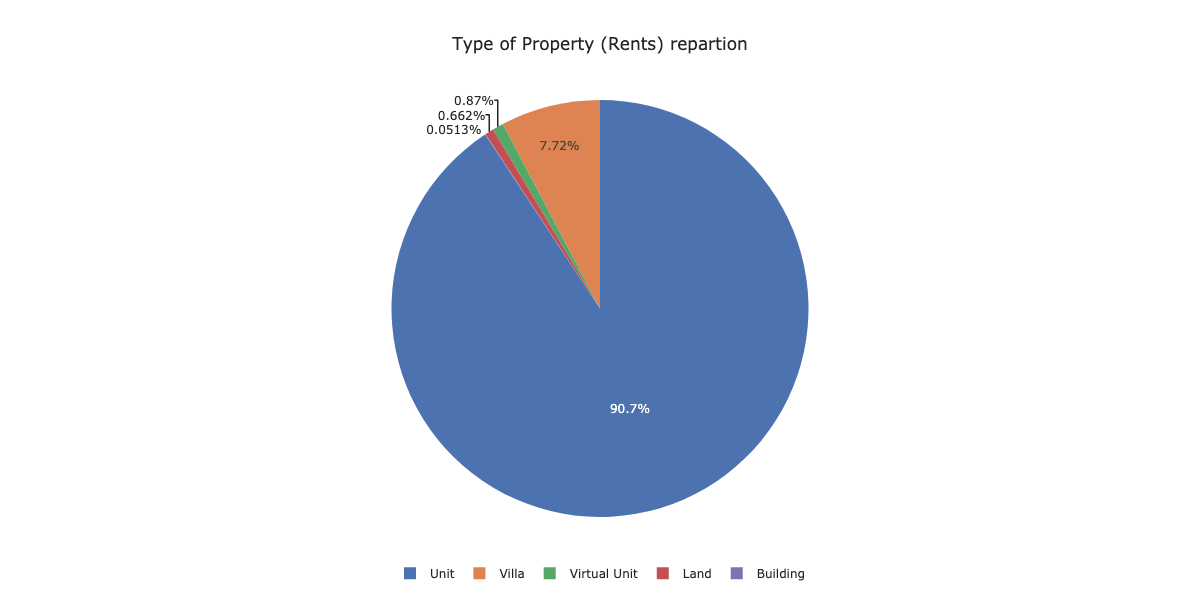

In [17]:
fig = px.pie(df_pt_value_counts, values='count', names='Property Type', title='Type of Property (Rents) repartion')
fig.update_layout(legend = dict(orientation = 'h', xanchor = "center", x = 0.5, y= -0.1))
fig.update_layout(width=1200, height=600)
fig.show("png")

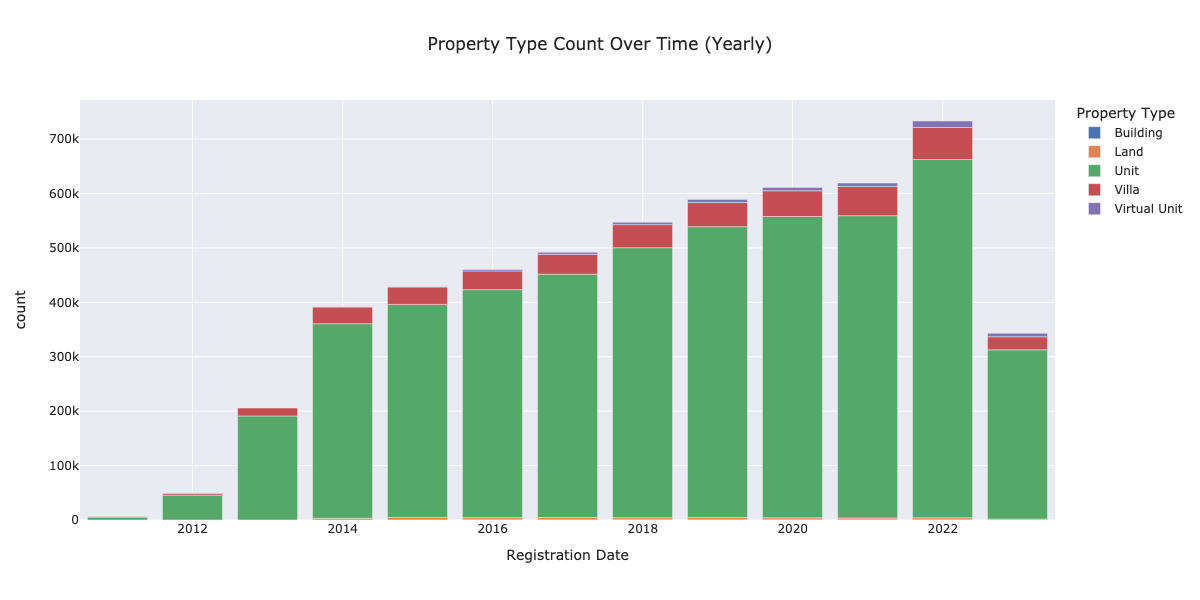

In [18]:
fig = px.bar(df_pt_value_counts_ot, x='Registration Date', y='count', color='Property Type', title='Property Type Count Over Time (Yearly)')
fig.update_layout(width=1200, height=600)
fig.show("png")

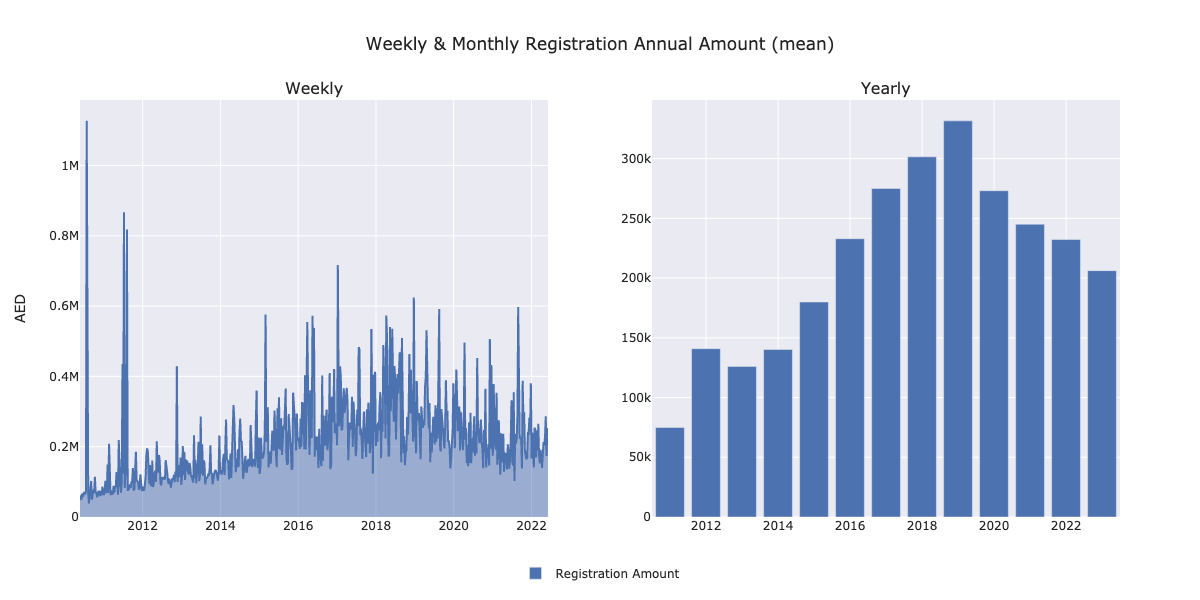

In [19]:
fig = make_subplots(
    subplot_titles=["Weekly", "Yearly"],
    rows=1, cols=2,
)

fig.add_trace(go.Scatter(name="Registration Amount", x=df_rents_weekly["Registration Date"], y=df_rents_weekly["Annual Amount"], fill='tozeroy', marker=dict(color=color), showlegend=False), row=1, col=1)
fig.add_trace(go.Bar(name="Registration Amount", x=df_rents_yearly["Registration Date"], y=df_rents_yearly["Annual Amount"], marker=dict(color=color)), row=1, col=2)

fig.update_yaxes(title_text='AED', col=1)
fig.update_layout(title={'text':'Weekly & Monthly Registration Annual Amount (mean)'})
fig.update_layout(legend = dict(orientation = 'h', xanchor = "center", x = 0.5, y= -0.1))
fig.update_layout(width=1200, height=600)
fig.show("png")

In [20]:
df_ifh_value_counts = column_value_counts(df_rents, 'Is Free Hold?')
df_ifh_value_counts_ot = df_rents.groupby(['Is Free Hold?', pd.Grouper(key="Registration Date", freq="Y")]).size().reset_index(name='count')

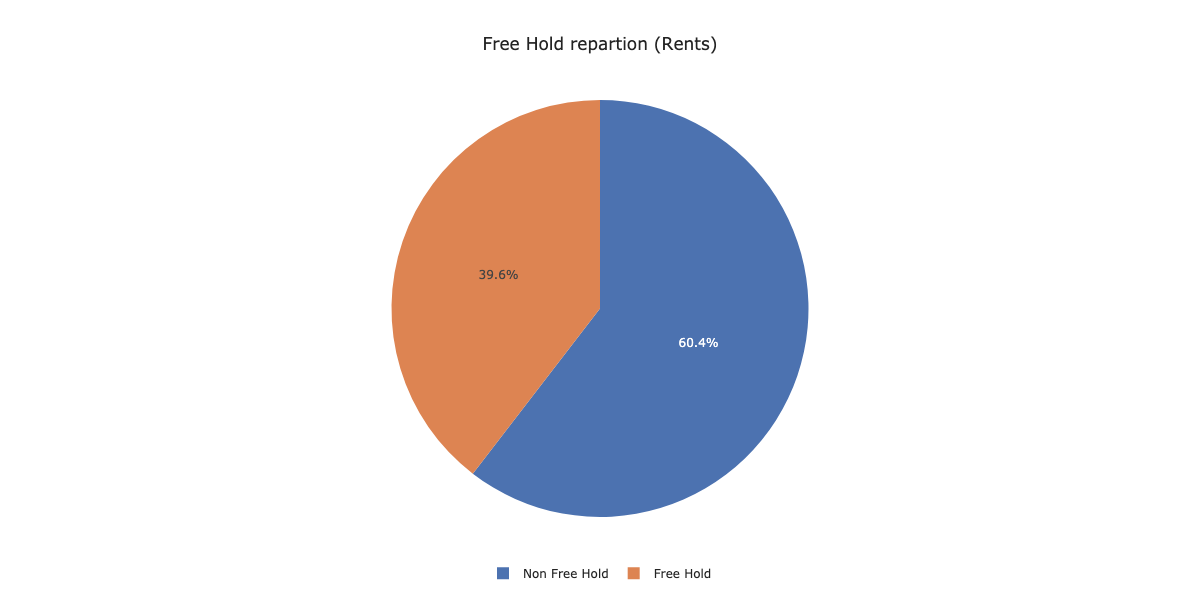

In [21]:
fig = px.pie(df_ifh_value_counts, values='count', names='Is Free Hold?', title='Free Hold repartion (Rents)')
fig.update_layout(legend = dict(orientation = 'h', xanchor = "center", x = 0.5, y= -0.1))
fig.update_layout(width=1200, height=600)
fig.show("png")

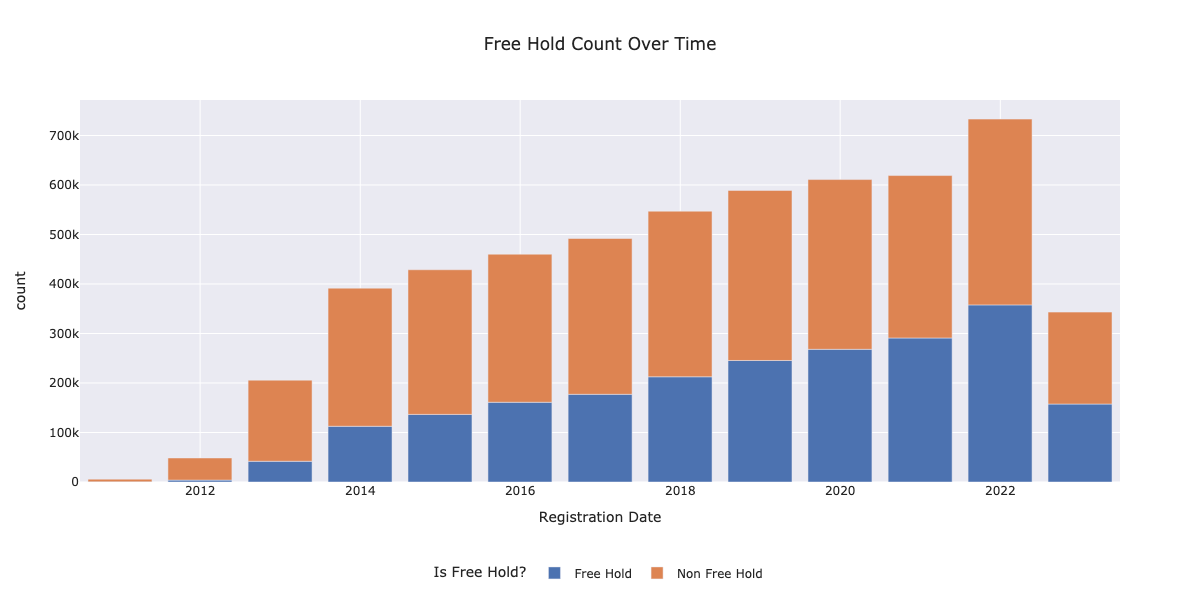

In [22]:
fig = px.bar(df_ifh_value_counts_ot, x='Registration Date', y='count', color='Is Free Hold?', title='Free Hold Count Over Time')
fig.update_layout(legend = dict(orientation = 'h', xanchor = "center", x = 0.5, y= -0.2))
fig.update_layout(width=1200, height=600)
fig.show("png")

In [23]:
df_usg_value_counts = column_value_counts(df_rents, 'Usage')
df_usg_value_counts_ot = df_rents.groupby(['Usage', pd.Grouper(key="Registration Date", freq="Y")]).size().reset_index(name='count')

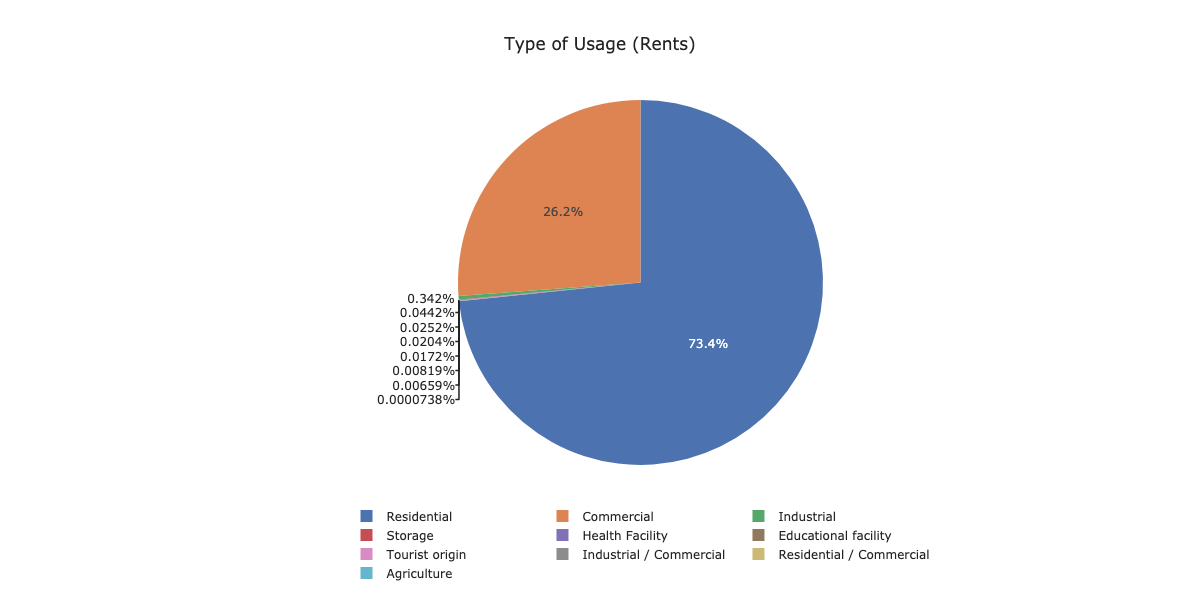

In [24]:
fig = px.pie(df_usg_value_counts, values='count', names='Usage', title='Type of Usage (Rents)')
fig.update_layout(legend = dict(orientation = 'h', xanchor = "center", x = 0.5, y= -0.1))
fig.update_layout(width=1200, height=600)
fig.show("png")

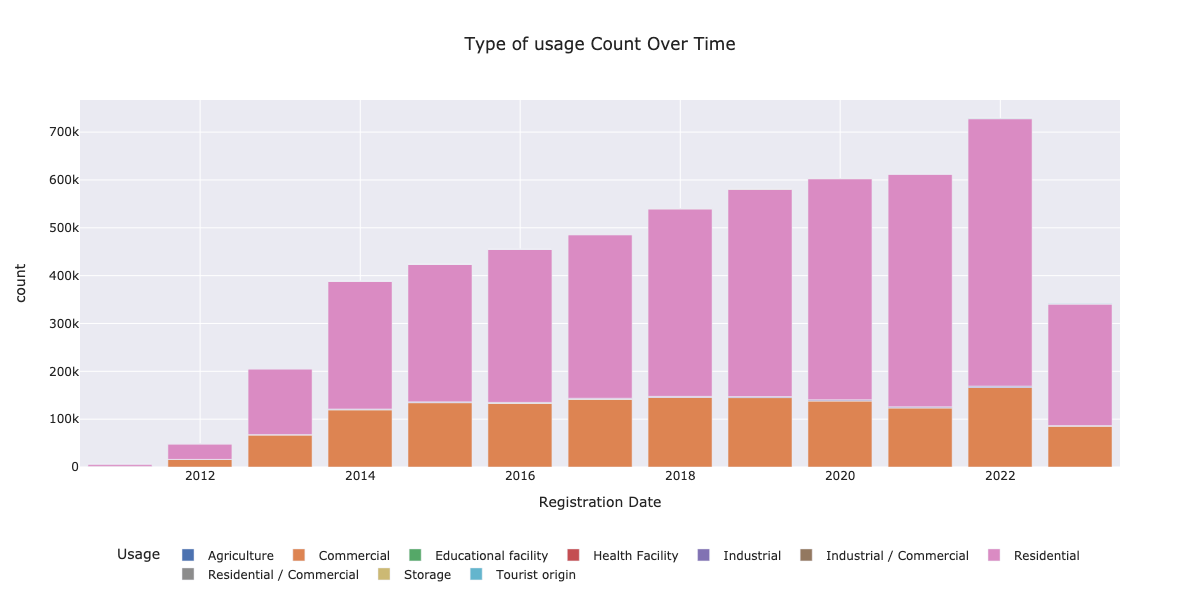

In [25]:
fig = px.bar(df_usg_value_counts_ot, x='Registration Date', y='count', color='Usage', title='Type of usage Count Over Time')
fig.update_layout(legend = dict(orientation = 'h', xanchor = "center", x = 0.5, y= -0.2))
fig.update_layout(width=1200, height=600)
fig.show("png")

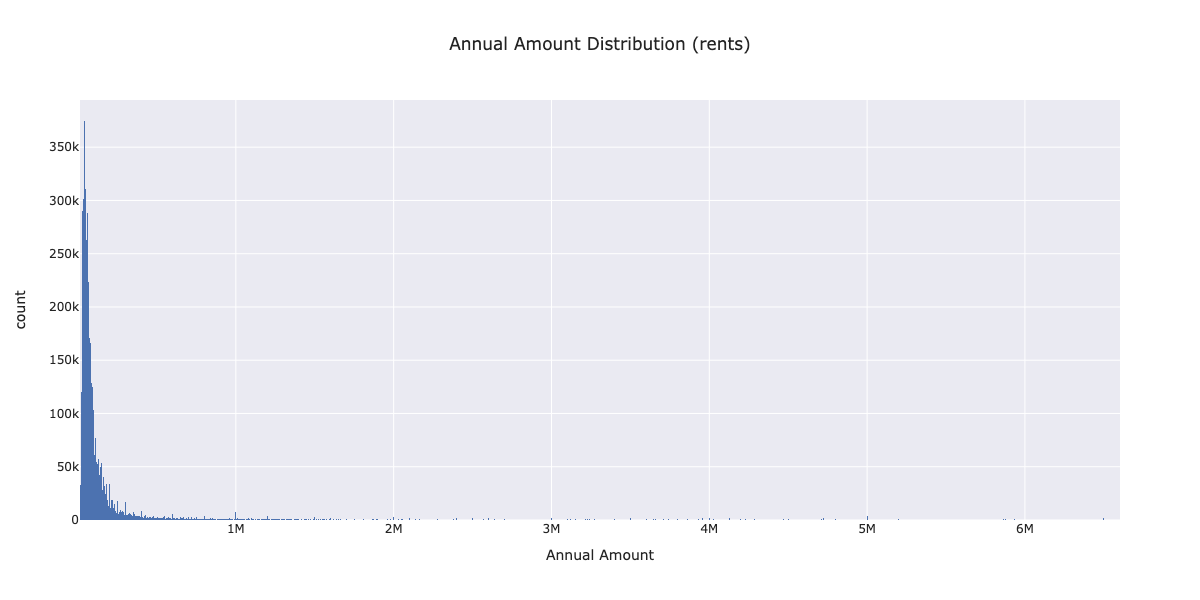

In [26]:
fig = px.histogram(df_rents, x='Annual Amount', title='Annual Amount Distribution (rents)')
fig.update_layout(legend = dict(orientation = 'h', xanchor = "center", x = 0.5, y= -0.1))
fig.update_layout(width=1200, height=600)
fig.show("png")

In [27]:
df_rents_price_area = df_rents.groupby("Area", as_index=False).agg({"Annual Amount":"mean", "feature_area_geocode_lat":"mean", "feature_area_geocode_lng":"mean", 'Property Size (sq.m)':"mean", "Ejari Contract Number":"count"})

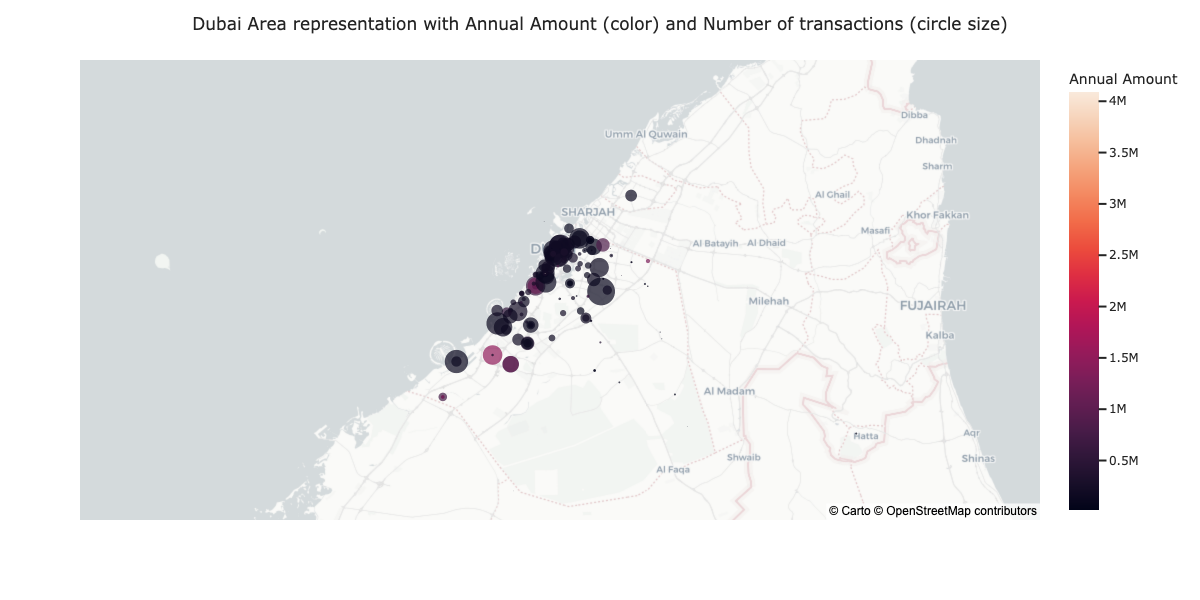

In [28]:
fig = px.scatter_mapbox(df_rents_price_area, lat="feature_area_geocode_lat", lon="feature_area_geocode_lng", size="Ejari Contract Number", color="Annual Amount", hover_name="Area", size_max=20, zoom=8,
                  mapbox_style="carto-positron")
fig.update_layout(title={'text':'Dubai Area representation with Annual Amount (color) and Number of transactions (circle size)'})
fig.update_layout(width=1200, height=600)
fig.show("png")

### Sales

In [29]:
def sales_group_by_freq(df, key, freq):
    return df.groupby([pd.Grouper(key=key, freq=freq)], as_index=False).agg({'Transaction Number':'count', 'Amount':'mean'})

df_transactions_weekly = sales_group_by_freq(df_transactions, key="Transaction Date", freq="W")
df_transactions_monthly = sales_group_by_freq(df_transactions, key="Transaction Date", freq="M")
df_transactions_yearly = sales_group_by_freq(df_transactions, key="Transaction Date", freq="Y")

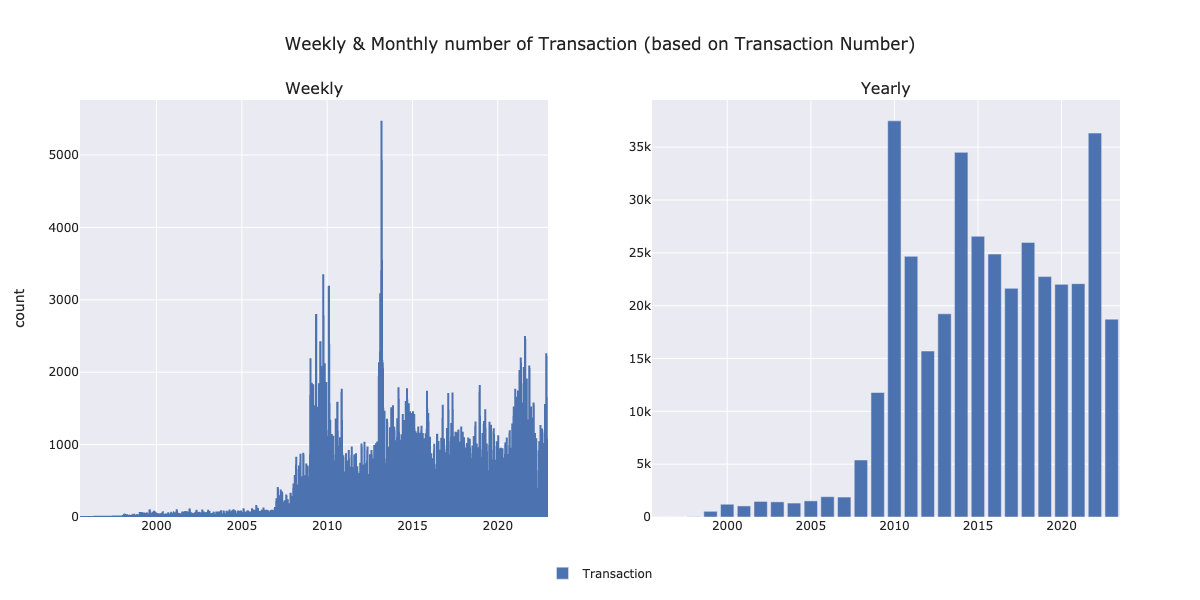

In [30]:
color = pio.templates[pio.templates.default].layout.colorway[0]
 
fig = make_subplots(
    subplot_titles=["Weekly", "Yearly"],
    rows=1, cols=2,
)

fig.add_trace(go.Scatter(name="Transaction", x=df_transactions_weekly["Transaction Date"], y=df_transactions_weekly["Transaction Number"], fill='tozeroy', marker=dict(color=color), showlegend=False), row=1, col=1)
fig.add_trace(go.Bar(name="Transaction", x=df_transactions_yearly["Transaction Date"], y=df_transactions_yearly["Transaction Number"], marker=dict(color=color)), row=1, col=2)
fig.update_yaxes(title_text='count', col=1)
fig.update_layout(title={'text':'Weekly & Monthly number of Transaction (based on Transaction Number)'})
fig.update_layout(legend = dict(orientation = 'h', xanchor = "center", x = 0.5, y= -0.1))
fig.update_layout(width=1200, height=600)
fig.show("png")

In [31]:
df_pt_value_counts = column_value_counts(df_transactions, 'Property Type')
df_pt_value_counts_ot = df_transactions.groupby(['Property Type', pd.Grouper(key="Transaction Date", freq="Y")]).size().reset_index(name='count')

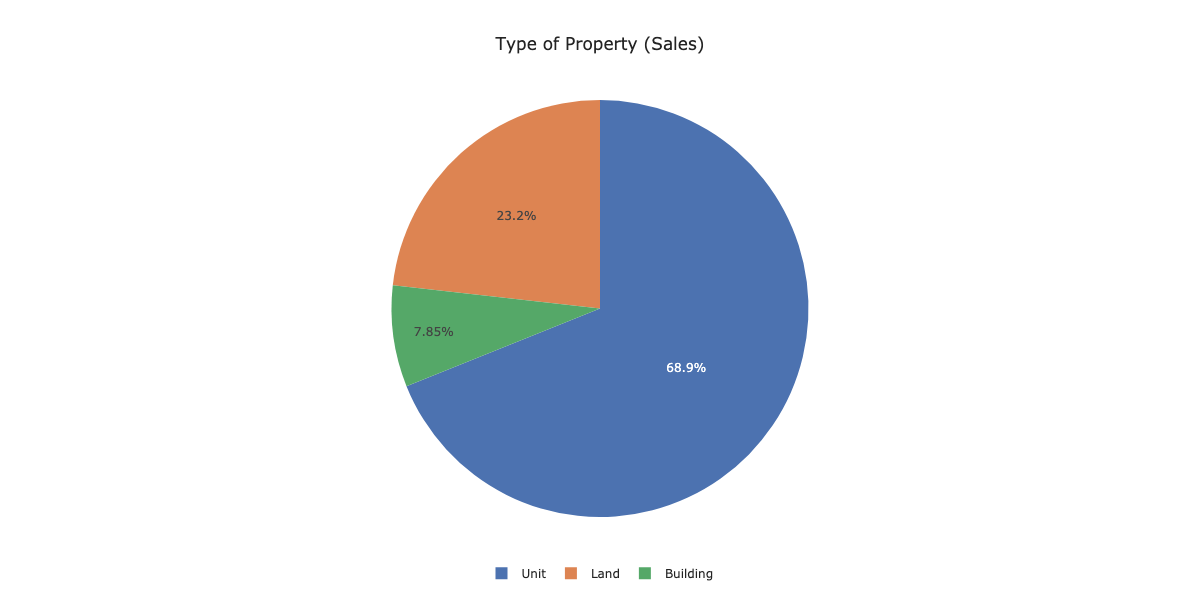

In [32]:
fig = px.pie(df_pt_value_counts, values='count', names='Property Type', title='Type of Property (Sales)')
fig.update_layout(legend = dict(orientation = 'h', xanchor = "center", x = 0.5, y= -0.1))
fig.update_layout(width=1200, height=600)
fig.show("png")

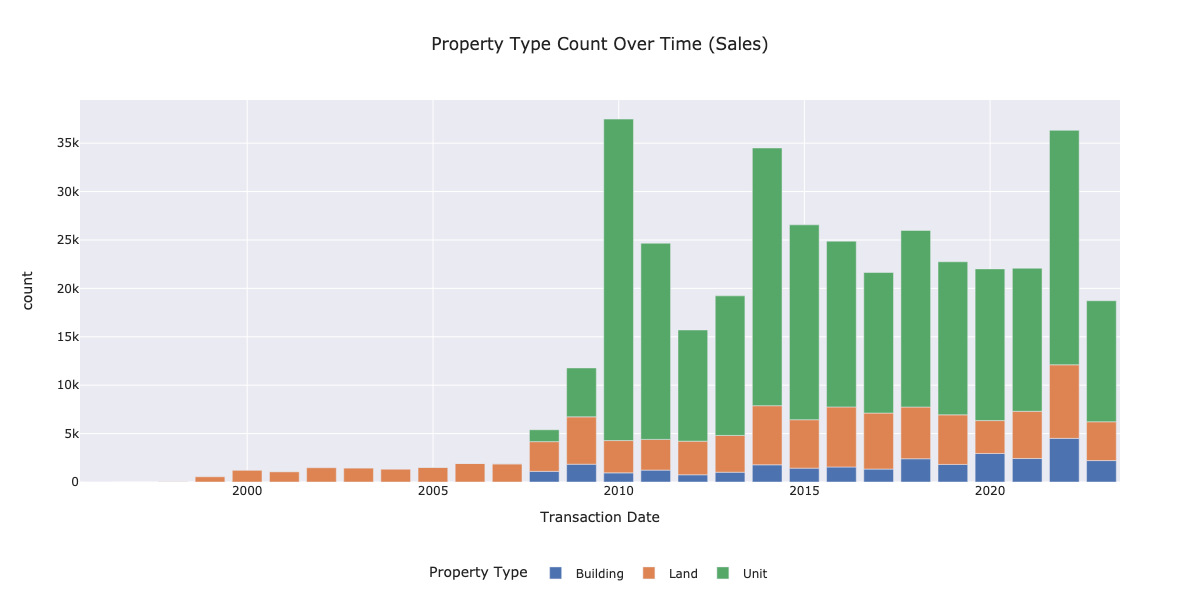

In [33]:
fig = px.bar(df_pt_value_counts_ot, x='Transaction Date', y='count', color='Property Type', title='Property Type Count Over Time (Sales)')
fig.update_layout(legend = dict(orientation = 'h', xanchor = "center", x = 0.5, y= -0.2))
fig.update_layout(width=1200, height=600)
fig.show("png")

In [34]:
df_usg_value_counts_transactions = column_value_counts(df_transactions, 'Usage')
df_usg_value_counts_ot_transactions = df_transactions.groupby(['Usage', pd.Grouper(key="Transaction Date", freq="Y")]).size().reset_index(name='count')

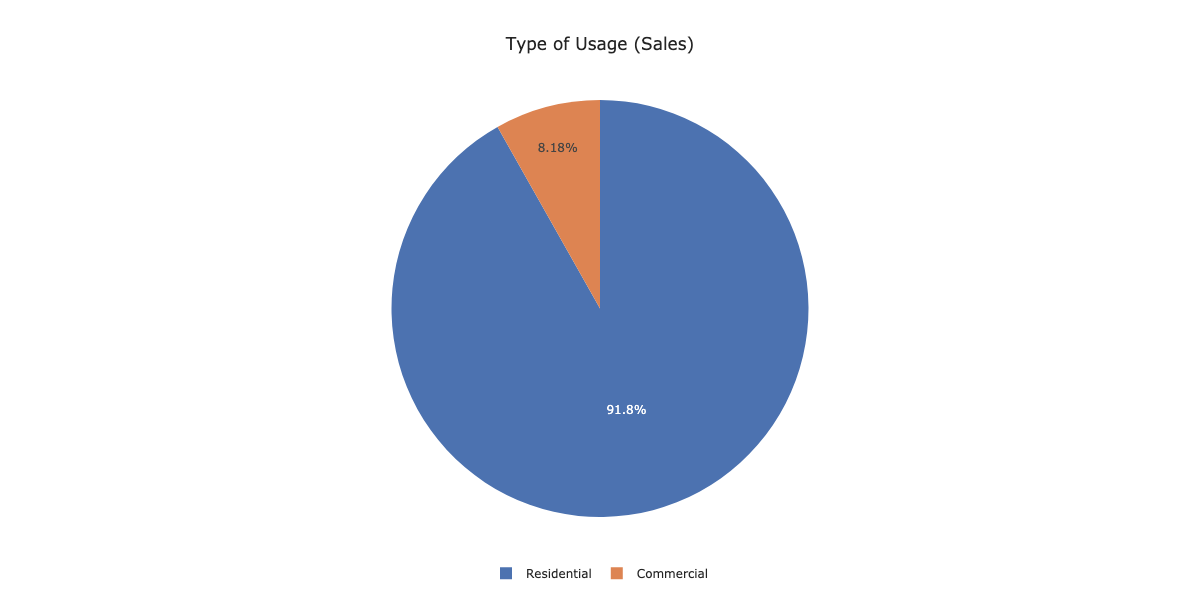

In [35]:
fig = px.pie(df_usg_value_counts_transactions, values='count', names='Usage', title='Type of Usage (Sales)')
fig.update_layout(legend = dict(orientation = 'h', xanchor = "center", x = 0.5, y= -0.1))
fig.update_layout(width=1200, height=600)
fig.show("png")

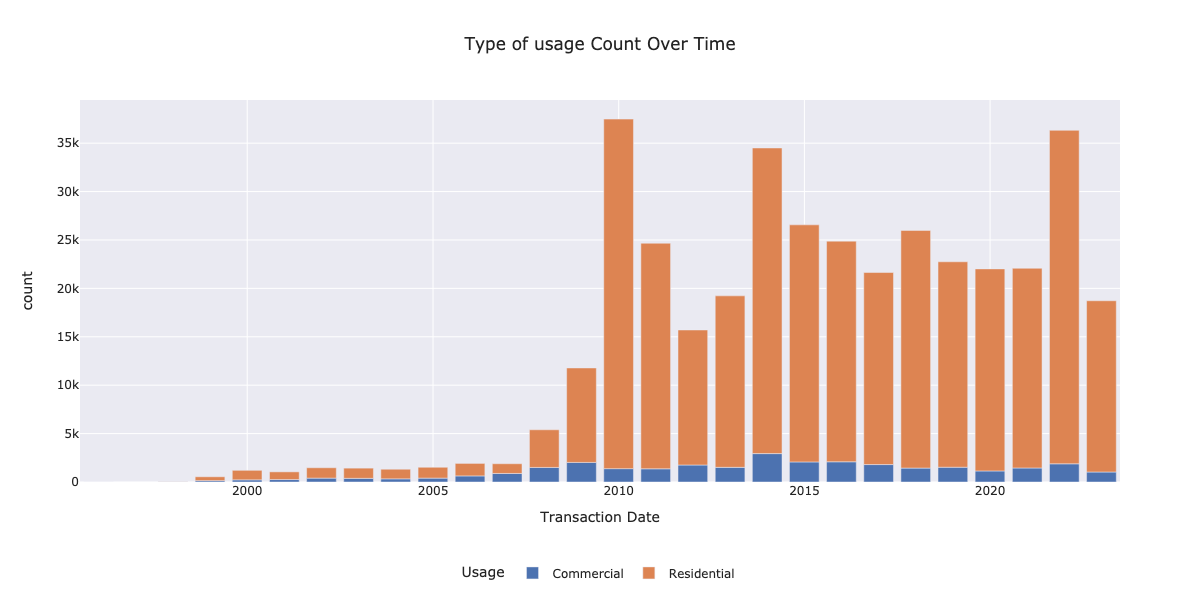

In [36]:
fig = px.bar(df_usg_value_counts_ot_transactions, x='Transaction Date', y='count', color='Usage', title='Type of usage Count Over Time')
fig.update_layout(legend = dict(orientation = 'h', xanchor = "center", x = 0.5, y= -0.2))
fig.update_layout(width=1200, height=600)
fig.show("png")

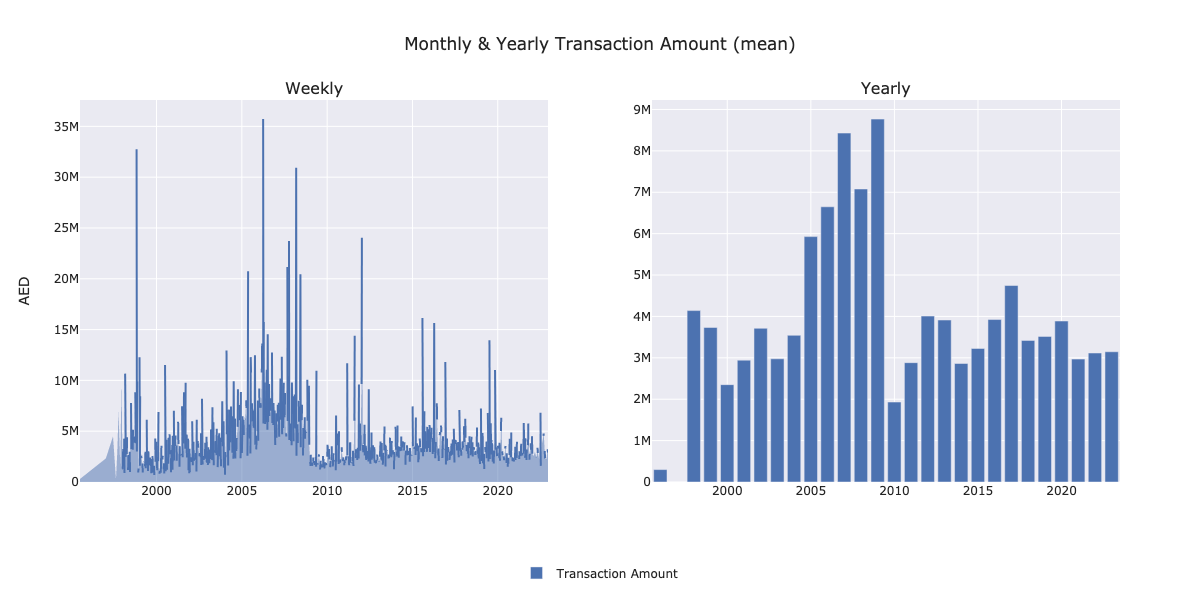

In [37]:
fig = make_subplots(
    subplot_titles=["Weekly", "Yearly"],
    rows=1, cols=2,
)

fig.add_trace(go.Scatter(name="Transaction", x=df_transactions_weekly["Transaction Date"], y=df_transactions_weekly["Amount"], fill='tozeroy', marker=dict(color=color), showlegend=False), row=1, col=1)
fig.add_trace(go.Bar(name="Transaction Amount", x=df_transactions_yearly["Transaction Date"], y=df_transactions_yearly["Amount"], marker=dict(color=color)), row=1, col=2)

fig.update_yaxes(title_text='AED', col=1)
fig.update_layout(title={'text':'Monthly & Yearly Transaction Amount (mean)'})
fig.update_layout(legend = dict(orientation = 'h', xanchor = "center", x = 0.5, y= -0.2))
fig.update_layout(width=1200, height=600)
fig.show("png")

In [38]:
df_ifh_value_counts = column_value_counts(df_transactions, 'Is Free Hold?')
df_ifh_value_counts_ot = df_transactions.groupby(['Is Free Hold?', pd.Grouper(key="Transaction Date", freq="Y")]).size().reset_index(name='count')

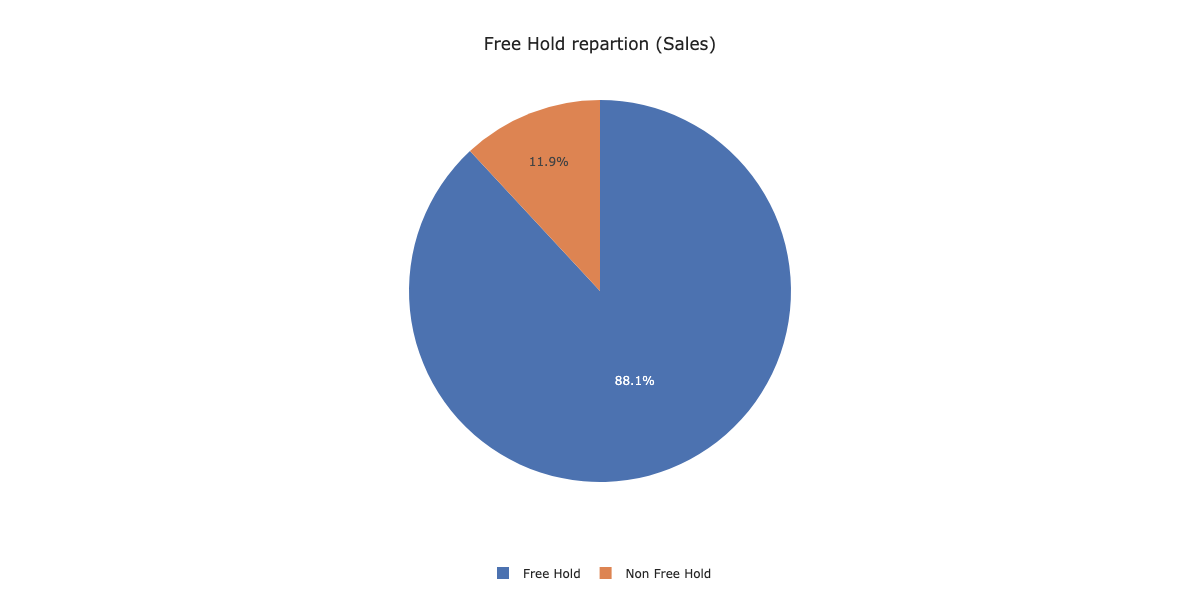

In [39]:
fig = px.pie(df_ifh_value_counts, values='count', names='Is Free Hold?', title='Free Hold repartion (Sales)')
fig.update_layout(legend = dict(orientation = 'h', xanchor = "center", x = 0.5, y= -0.2))
fig.update_layout(width=1200, height=600)
fig.show("png")

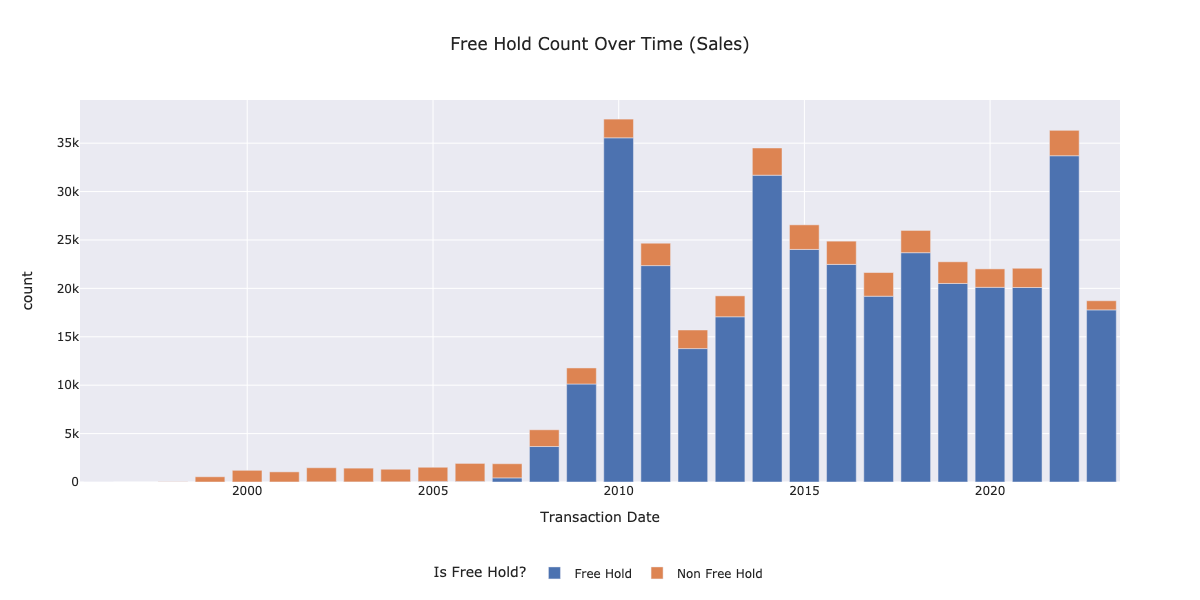

In [40]:
fig = px.bar(df_ifh_value_counts_ot, x='Transaction Date', y='count', color='Is Free Hold?', title='Free Hold Count Over Time (Sales)')
fig.update_layout(legend = dict(orientation = 'h', xanchor = "center", x = 0.5, y= -0.2))
fig.update_layout(width=1200, height=600)
fig.show("png")

In [41]:
df_repartition_seller_buyer = df_transactions.groupby([pd.Grouper(key="Transaction Date", freq="M")]).agg({"No. of Buyer":"sum", "No. of Seller":"sum"})

In [42]:
df_repartition_seller_buyer['No. of Buyer Norm'] = 100*df_repartition_seller_buyer['No. of Buyer'] / (df_repartition_seller_buyer['No. of Buyer'] + df_repartition_seller_buyer['No. of Seller'])
df_repartition_seller_buyer['No. of Seller Norm'] = 100*df_repartition_seller_buyer['No. of Seller'] / (df_repartition_seller_buyer['No. of Buyer'] + df_repartition_seller_buyer['No. of Seller'])

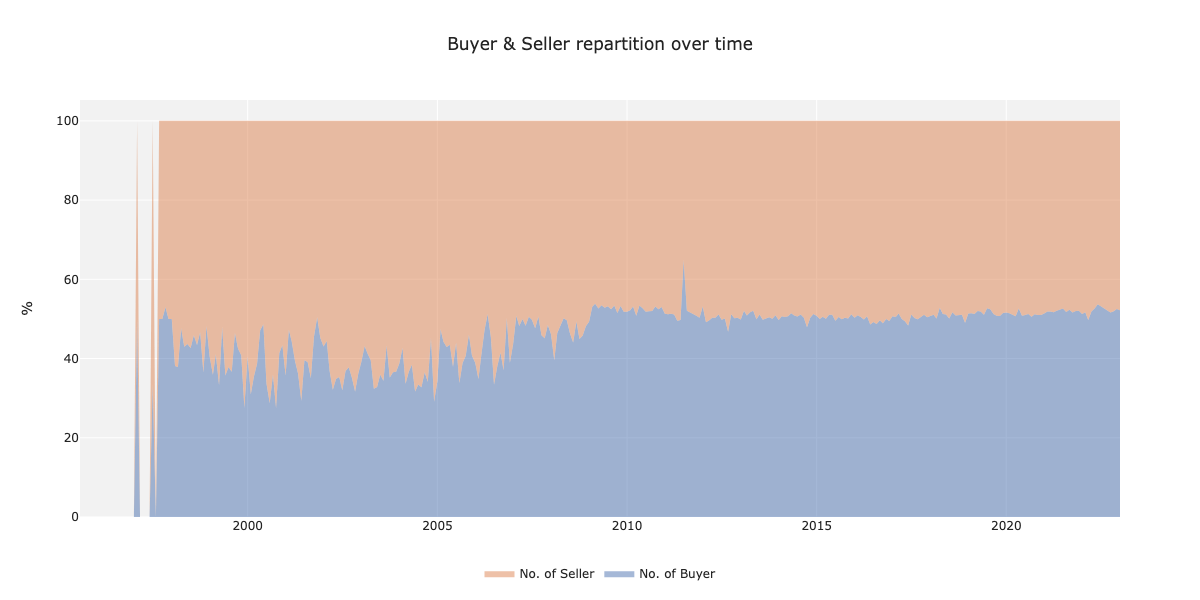

In [43]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    name="No. of Buyer",
    x=df_repartition_seller_buyer.index, y=df_repartition_seller_buyer['No. of Buyer Norm'],
    stackgroup='one', line=dict(width=0)
))

fig.add_trace(go.Scatter(
    name="No. of Seller",
    x=df_repartition_seller_buyer.index, y=df_repartition_seller_buyer['No. of Seller Norm'],
    stackgroup='one', line=dict(width=0)
))

fig.update_layout({'plot_bgcolor': 'rgba(0,0,0,0.05)'}, legend = dict(orientation = 'h', xanchor = "center", x = 0.5, y= -0.1))
fig.update_yaxes(title_text='%')
fig.update_layout(title={'text':'Buyer & Seller repartition over time'})
fig.update_layout(width=1200, height=600)
fig.update_layout(width=1200, height=600)
fig.show("png")

In [44]:
df_transactions_price_area = df_transactions.groupby("Area", as_index=False).agg({"Amount":"mean", "feature_area_geocode_lat":"mean", "feature_area_geocode_lng":"mean", 'Property Size (sq.m)':"mean", "Transaction Number":"count"})

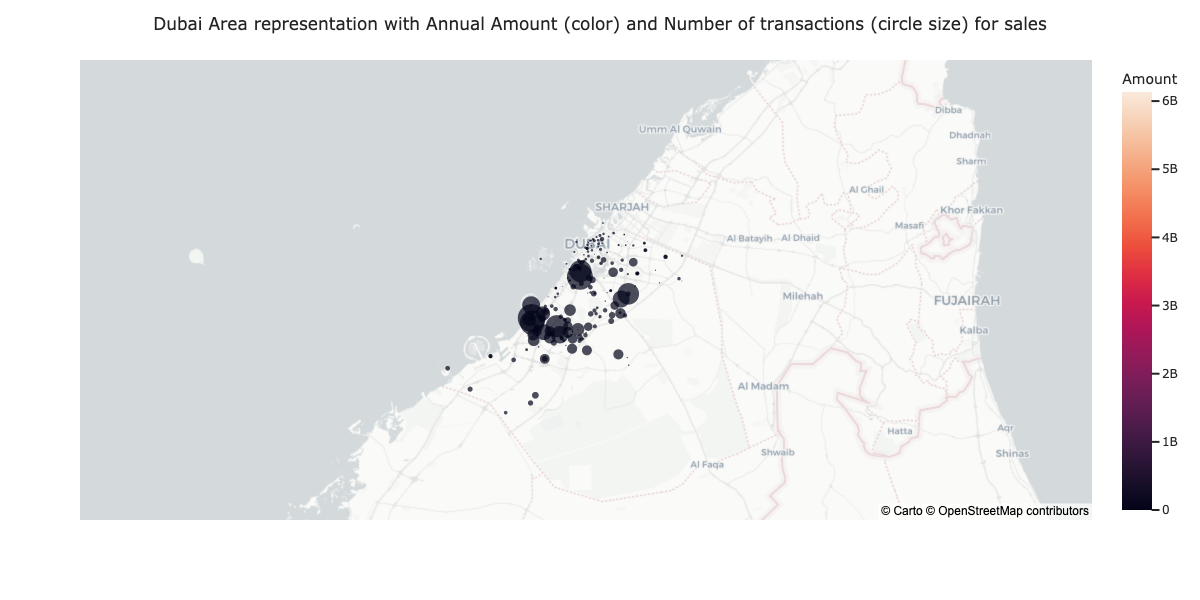

In [45]:
fig = px.scatter_mapbox(df_transactions_price_area, lat="feature_area_geocode_lat", lon="feature_area_geocode_lng", size="Transaction Number", color="Amount", hover_name="Area", size_max=20, zoom=8,
                  mapbox_style="carto-positron")
fig.update_layout(title={'text':'Dubai Area representation with Annual Amount (color) and Number of transactions (circle size) for sales'})
fig.update_layout(width=1200, height=600)
fig.show("png")

## 2. Correlation Surface area in m2 and sale/rental price

### Rents

In [46]:
df_rents_tmp = df_rents.copy(deep=True)
df_rents_tmp = df_rents_tmp.dropna(subset=['Annual Amount', 'Property Size (sq.m)'])
df_rents_tmp = df_rents_tmp.drop_duplicates(subset=['Annual Amount', 'Property Size (sq.m)'])

In [47]:
df_rents_tmp["Annual Amount"].corr(df_rents_tmp["Property Size (sq.m)"])

0.09179212234304379

In [48]:
def price_area_corr_grouped(df_rents_tmp, gouped_col):
    df_rents_tmp_gb = df_rents_tmp.groupby([gouped_col], as_index=False).agg({"Annual Amount":"mean", "Property Size (sq.m)":"mean", "feature_area_geocode_lat":"mean", "feature_area_geocode_lng":"mean"})
    return df_rents_tmp_gb["Annual Amount"].corr(df_rents_tmp_gb["Property Size (sq.m)"])

corr_area = price_area_corr_grouped(df_rents_tmp, "Area")
corr_ecn = price_area_corr_grouped(df_rents_tmp, "Ejari Contract Number")
corr_pt = price_area_corr_grouped(df_rents_tmp, "Property Type")
corr_usg = price_area_corr_grouped(df_rents_tmp, "Usage")
corr_prj = price_area_corr_grouped(df_rents_tmp, "Project")

corr_area, corr_ecn, corr_pt, corr_usg, corr_prj

(0.24554845273254705,
 0.2094634460712807,
 0.756347002207012,
 -0.18026467754682143,
 0.3670553439067765)

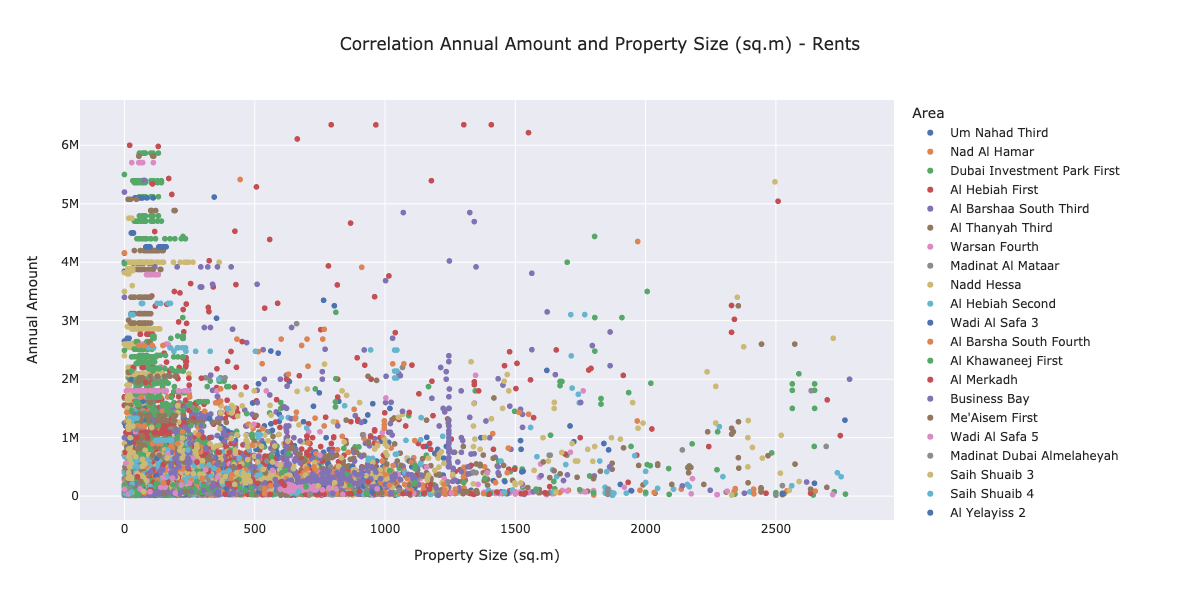

In [49]:
fig = px.scatter(df_rents_tmp.head(100000), x='Property Size (sq.m)', y='Annual Amount', color='Area', title="Correlation Annual Amount and Property Size (sq.m) - Rents")
fig.update_layout(width=1200, height=600)
fig.show("png")

### Sales

In [50]:
df_transactions_tmp = df_transactions.copy(deep=True)
df_transactions_tmp = df_transactions_tmp.dropna(subset=['Amount', 'Property Size (sq.m)'])
df_transactions_tmp = df_transactions_tmp.drop_duplicates(subset=['Amount', 'Property Size (sq.m)'])

In [51]:
df_transactions_tmp["Amount"].corr(df_transactions_tmp["Property Size (sq.m)"])

0.3544100786212215

In [52]:
def price_area_corr_grouped(df_transactions_tmp, gouped_col):
    df_transactions_tmp_gb = df_transactions_tmp.groupby([gouped_col], as_index=False).agg({"Amount":"mean", "Property Size (sq.m)":"mean", "feature_area_geocode_lat":"mean", "feature_area_geocode_lng":"mean"})
    return df_transactions_tmp_gb["Amount"].corr(df_transactions_tmp_gb["Property Size (sq.m)"])

corr_area = price_area_corr_grouped(df_transactions_tmp, "Area")
corr_tt = price_area_corr_grouped(df_transactions_tmp, "Transaction Type")
corr_pt = price_area_corr_grouped(df_transactions_tmp, "Property Type")
corr_usg = price_area_corr_grouped(df_transactions_tmp, "Usage")
corr_prj = price_area_corr_grouped(df_transactions_tmp, "Project")

corr_area, corr_tt, corr_pt, corr_usg, corr_prj

(0.455594879185766,
 0.9960934819458163,
 0.9928315863595955,
 1.0,
 0.5498828875785525)

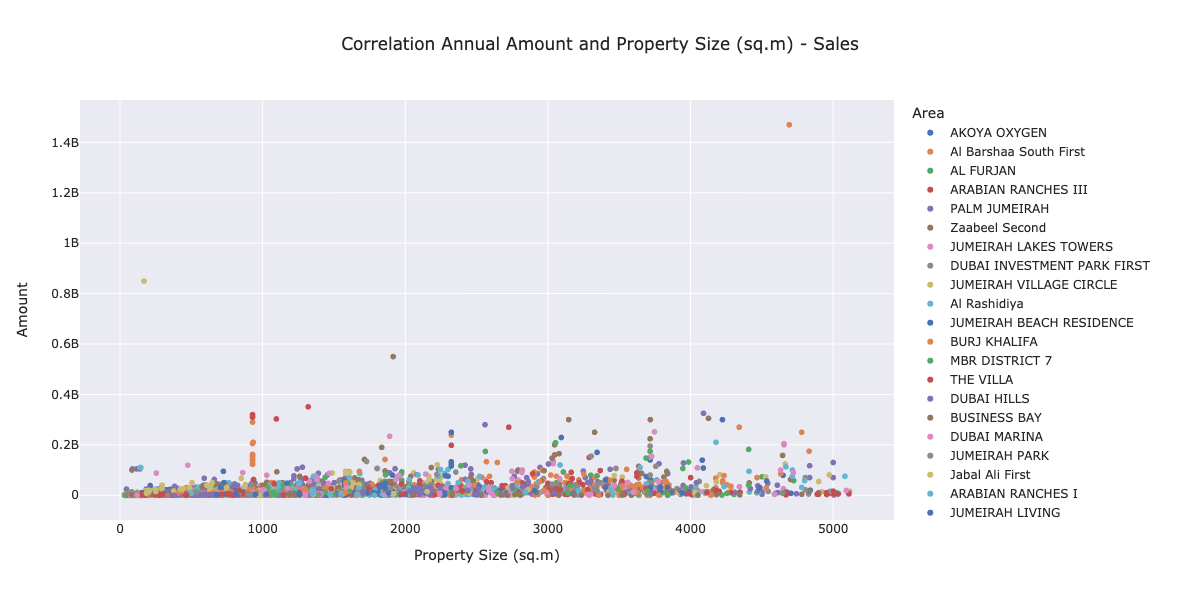

In [53]:
fig = px.scatter(df_transactions_tmp.head(100000), x='Property Size (sq.m)', y='Amount', color='Area', title="Correlation Annual Amount and Property Size (sq.m) - Sales")
fig.update_layout(width=1200, height=600)
fig.show("png")

## 3. Rental/Sale evolving trends

In [54]:
df_rents_tmp = df_rents.copy(deep=True)
df_transactions_tmp = df_transactions.copy(deep=True)

In [55]:
df_rents_tmp['Rent Per Sq.m'] = df_rents_tmp['Annual Amount'] / df_rents_tmp['Property Size (sq.m)']
df_transactions_tmp['Sale Per Sq.m'] = df_transactions_tmp['Amount'] / df_transactions_tmp['Property Size (sq.m)']

In [56]:
df_rents_tmp.replace([np.inf, -np.inf], np.nan, inplace=True)
df_rents_tmp.dropna(subset='Rent Per Sq.m', inplace=True)

In [57]:
df_transactions_avg_sale_price = df_transactions_tmp.groupby([pd.Grouper(key="Transaction Date", freq="M")], as_index=False).agg({'Amount':'mean', 'Sale Per Sq.m':'mean'})
df_transactions_avg_rent_price = df_rents_tmp.groupby([pd.Grouper(key="Registration Date", freq="M")], as_index=False).agg({'Annual Amount':'mean', 'Rent Per Sq.m':'mean'})

In [58]:
df_merge_avg_sale_rent = df_transactions_avg_sale_price.merge(df_transactions_avg_rent_price, left_on='Transaction Date', right_on='Registration Date')

In [59]:
df_merge_avg_sale_rent['Rent Per Sq.m Norm'] = 100*df_merge_avg_sale_rent['Rent Per Sq.m'] / (df_merge_avg_sale_rent['Rent Per Sq.m'] + df_merge_avg_sale_rent['Sale Per Sq.m'])
df_merge_avg_sale_rent['Sale Per Sq.m Norm'] = 100*df_merge_avg_sale_rent['Sale Per Sq.m'] / (df_merge_avg_sale_rent['Rent Per Sq.m'] + df_merge_avg_sale_rent['Sale Per Sq.m'])

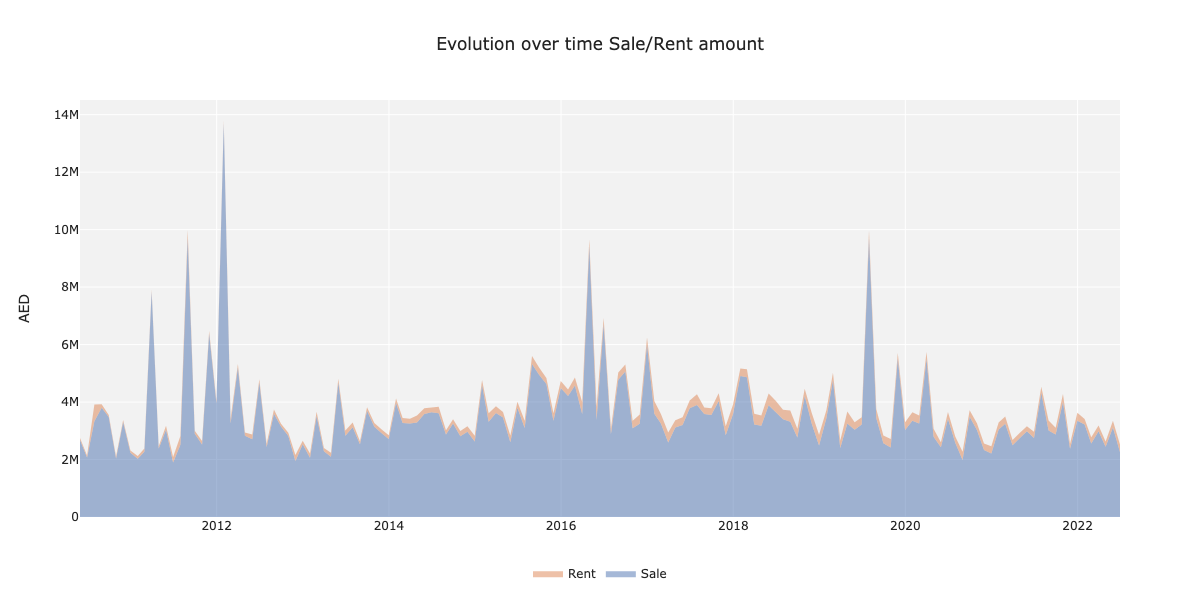

In [60]:
fig = go.Figure()


fig.add_trace(go.Scatter(
    name="Sale",
    x=df_merge_avg_sale_rent["Transaction Date"], y=df_merge_avg_sale_rent['Amount'],
    stackgroup='one', line=dict(width=0)
))

fig.add_trace(go.Scatter(
    name="Rent",
    x=df_merge_avg_sale_rent["Transaction Date"], y=df_merge_avg_sale_rent['Annual Amount'],
    stackgroup='one', line=dict(width=0)
))

fig.update_layout({'plot_bgcolor': 'rgba(0,0,0,0.05)'}, legend = dict(orientation = 'h', xanchor = "center", x = 0.5, y= -0.1))
fig.update_layout(title=f"Evolution over time Sale/Rent amount")
fig.update_layout(width=1200, height=600)
fig.update_yaxes(title_text='AED')
fig.update_layout(width=1200, height=600)
fig.show("png")

In [61]:
df_merge_avg_sale_rent['Amount'].corr(df_merge_avg_sale_rent['Annual Amount'])

0.005167537000274493

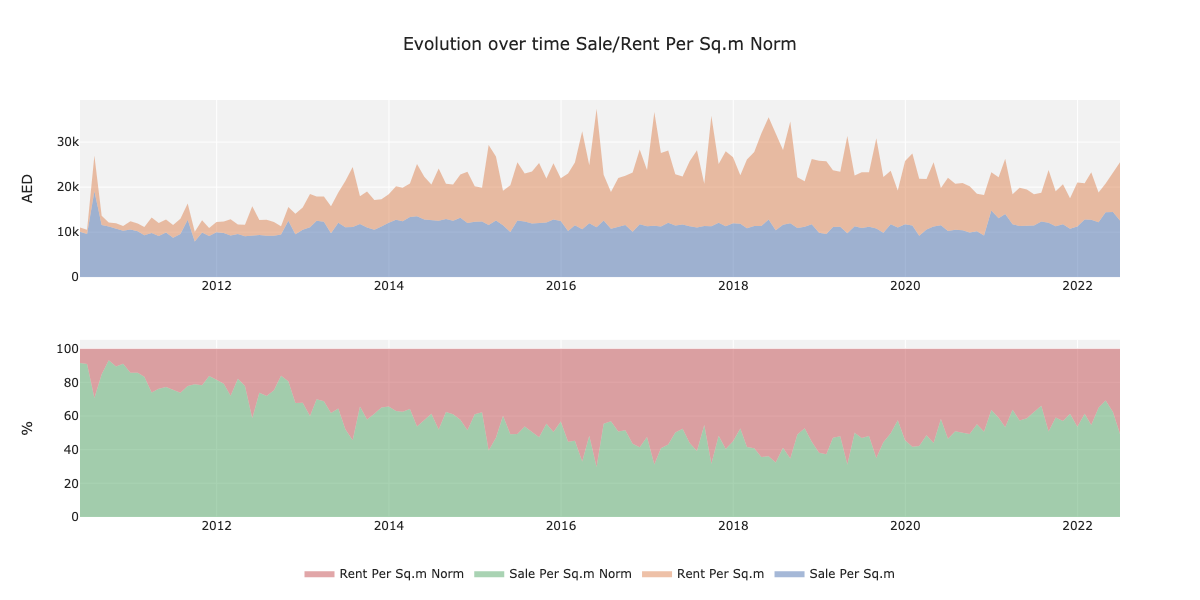

In [62]:
fig = make_subplots(rows=2, cols=1, shared_yaxes=True)

fig.add_trace(go.Scatter(
    name="Sale Per Sq.m",
    x=df_merge_avg_sale_rent["Transaction Date"], y=df_merge_avg_sale_rent['Sale Per Sq.m'],
    stackgroup='one', line=dict(width=0)
), row=1, col=1)

fig.add_trace(go.Scatter(
    name="Rent Per Sq.m",
    x=df_merge_avg_sale_rent["Transaction Date"], y=df_merge_avg_sale_rent['Rent Per Sq.m'],
    stackgroup='one', line=dict(width=0)
), row=1, col=1)

fig.add_trace(go.Scatter(
    name="Sale Per Sq.m Norm",
    x=df_merge_avg_sale_rent["Transaction Date"], y=df_merge_avg_sale_rent['Sale Per Sq.m Norm'],
    stackgroup='one', line=dict(width=0)
), row=2, col=1)

fig.add_trace(go.Scatter(
    name="Rent Per Sq.m Norm",
    x=df_merge_avg_sale_rent["Transaction Date"], y=df_merge_avg_sale_rent['Rent Per Sq.m Norm'],
    stackgroup='one', line=dict(width=0)
), row=2, col=1)

fig.update_layout({'plot_bgcolor': 'rgba(0,0,0,0.05)'}, legend = dict(orientation = 'h', xanchor = "center", x = 0.5, y= -0.1))
fig.update_layout(title=f"Evolution over time Sale/Rent Per Sq.m Norm")
fig.update_layout(width=1200, height=600)
fig.update_yaxes(title_text='AED', row=1)
fig.update_yaxes(title_text='%', row=2)
fig.update_layout(width=1200, height=600)
fig.show("png")

In [63]:
df_merge_avg_sale_rent['Rent Per Sq.m'].corr(df_merge_avg_sale_rent['Sale Per Sq.m'])

0.2092247608967951

In [64]:
df_rents_tmp = df_rents.copy(deep=True)
df_transactions_tmp = df_transactions.copy(deep=True)

In [65]:
# Sort the dataframes by Property ID and date
rents = df_rents_tmp.sort_values(['Registration Date'])
transactions = df_transactions_tmp.sort_values(['Transaction Date'])

transactions = transactions.dropna(subset=['Transaction Date', 'Property ID'])
rents = rents.dropna(subset=['Registration Date', 'Property ID'])

# Merge using merge_asof 
merged = pd.merge_asof(transactions, rents, left_on='Transaction Date', right_on='Registration Date', by='Property ID', direction='backward', suffixes=('_sale', '_rent'))

# Filter rows where sale amount and annual rent are both > 0
merged = merged[(merged['Annual Amount'] > 0) & (merged['Amount'] > 0)]

# Calculate the rate of return
merged['Rate of Return'] = merged['Annual Amount'] / merged['Amount']

In [66]:
upper_threshold = merged['Rate of Return'].quantile(0.99)

# remove anything that's in the top 1%
merged_filtered = merged[merged['Rate of Return'] <= upper_threshold]


In [67]:
merged_gb = merged_filtered.groupby([pd.Grouper(key="Transaction Date", freq="M")]).agg({"Rate of Return":"mean"})

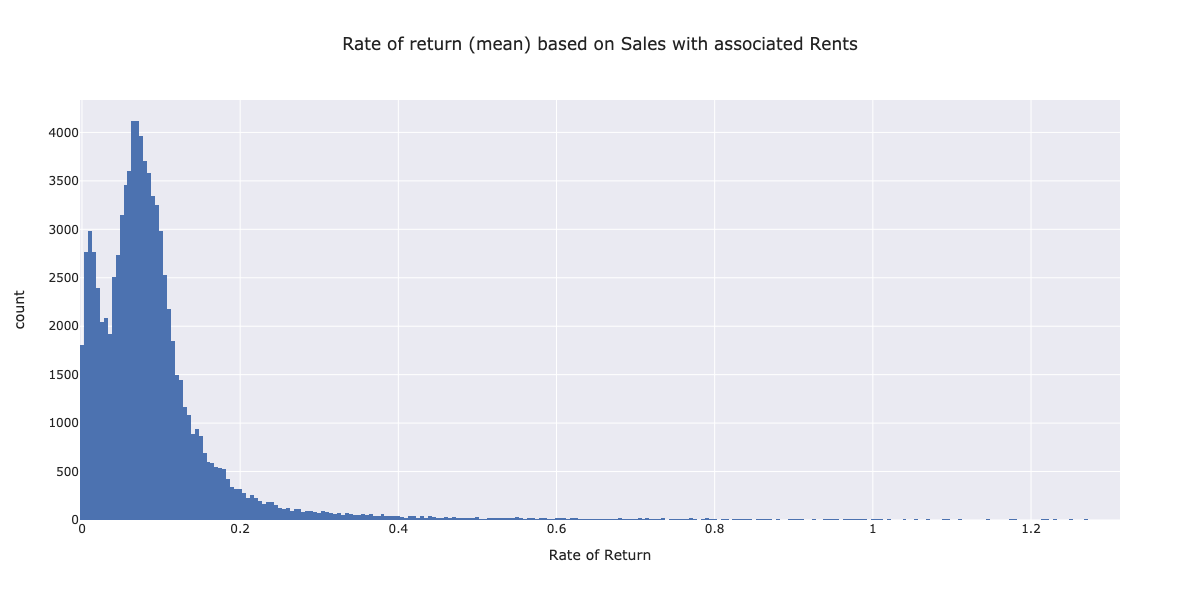

In [68]:
fig = px.histogram(merged_filtered, x='Rate of Return', title="Rate of return (mean) based on Sales with associated Rents")
fig.update_layout(width=1200, height=600)
fig.show("png")

## 4. Impact factors in sale/rental price over time

In [69]:
df_rents_tmp = df_rents.copy(deep=True)

# Prediction Models

## Features

In [70]:
categorical_features_rents = ["Property Sub Type", "Usage", "Master Project", "Project"]

In [71]:
df_rents_features = df_rents.copy(deep=True)

In [72]:
earliest_date = df_rents_features.groupby('Property ID')['Start Date'].min()
df_rents_features = df_rents_features.merge(earliest_date.rename('First Rented'), on='Property ID')
df_rents_features['feature_property_age'] = (df_rents_features['Start Date'] - df_rents_features['First Rented']).dt.days / 365.25

In [73]:
df_rents_features["Master Project"] = df_rents_features["Master Project"].fillna("None")
df_rents_features["Project"] = df_rents_features["Project"].fillna("None")

In [74]:
df_rents_features["feature_time_duration"]   = (df_rents["End Date"] - df_rents["Start Date"]).apply(lambda x: x.total_seconds())

df_rents_features["feature_property_size"]   = df_rents["Property Size (sq.m)"]
df_rents_features["feature_nb_rooms"]        = df_rents["Number of Rooms"].fillna(0)
df_rents_features["feature_parking"]         = df_rents["Parking"].notna().astype(int)
df_rents_features["feature_units"]           = df_rents["No of Units"]
df_rents_features['feature_is_free_hold']    = df_rents['Is Free Hold?'].map({'Free Hold': True, 'Non Free Hold': False}).astype(int)
df_rents_features['feature_version']         = df_rents['Version'].map({'New': True, 'Renewed': False}).astype(int)

df_rents_features = pd.get_dummies(df_rents_features, columns=['Property Type'])

In [75]:
df_rents_features['feature_size_per_room'] = df_rents_features['feature_property_size'] / df_rents_features['feature_nb_rooms']
df_rents_features['feature_size_per_room'] = df_rents_features['feature_size_per_room'].fillna(0)

In [76]:
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, (lat1, lon1, lat2, lon2))

    R = 6371.0

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c

    return distance

df_rents_features['feature_dist_to_nearest_metro']    = haversine(df_rents_features['feature_area_geocode_lat'], df_rents_features['feature_area_geocode_lng'], df_rents_features['feature_nearest_metro_geocode_lat'], df_rents_features['feature_nearest_metro_geocode_lng'])
df_rents_features['feature_dist_to_nearest_mall']     = haversine(df_rents_features['feature_area_geocode_lat'], df_rents_features['feature_area_geocode_lng'], df_rents_features['feature_nearest_mall_geocode_lat'], df_rents_features['feature_nearest_mall_geocode_lng'])
df_rents_features['feature_dist_to_nearest_landmark'] = haversine(df_rents_features['feature_area_geocode_lat'], df_rents_features['feature_area_geocode_lng'], df_rents_features['feature_nearest_landmark_geocode_lat'], df_rents_features['feature_nearest_landmark_geocode_lng'])

In [77]:
df_rents_features["target_annual_amount"] = df_rents["Annual Amount"]

In [78]:
from sklearn.preprocessing import LabelEncoder

for c in categorical_features_rents:
    lbl = LabelEncoder()
    c_feature = 'feature_'+c.lower().replace(' ', '_')
    lbl.fit(list(df_rents[c].values)) 
    df_rents_features[c_feature] = lbl.transform(list(df_rents[c].values))

Missing values ratio

In [79]:
all_data_na = (df_rents_features[[col for col in df_rents_features if col.startswith('feature_')]].isnull().sum() / len(df_rents_features)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(60)

,Missing Ratio
feature_dist_to_nearest_mall,10.944670
feature_nearest_mall_geocode_lat,10.938898
feature_nearest_mall_geocode_lng,10.938898
feature_dist_to_nearest_metro,10.271992
feature_nearest_metro_geocode_lat,10.266184
feature_nearest_metro_geocode_lng,10.266184
feature_dist_to_nearest_landmark,6.339063
feature_nearest_landmark_geocode_lat,6.333273
feature_nearest_landmark_geocode_lng,6.333273
feature_property_size,1.293631


Remove rows that we couldn't fill

In [80]:
df_rents_features = df_rents_features.replace([np.inf, -np.inf], np.nan)
df_rents_to_train = df_rents_features[[col for col in df_rents_features if col.startswith('feature_')] + ["target_annual_amount"]].dropna()
df_rents_features = df_rents_features.dropna(subset=[col for col in df_rents_features if col.startswith('feature_')] + ["target_annual_amount"])

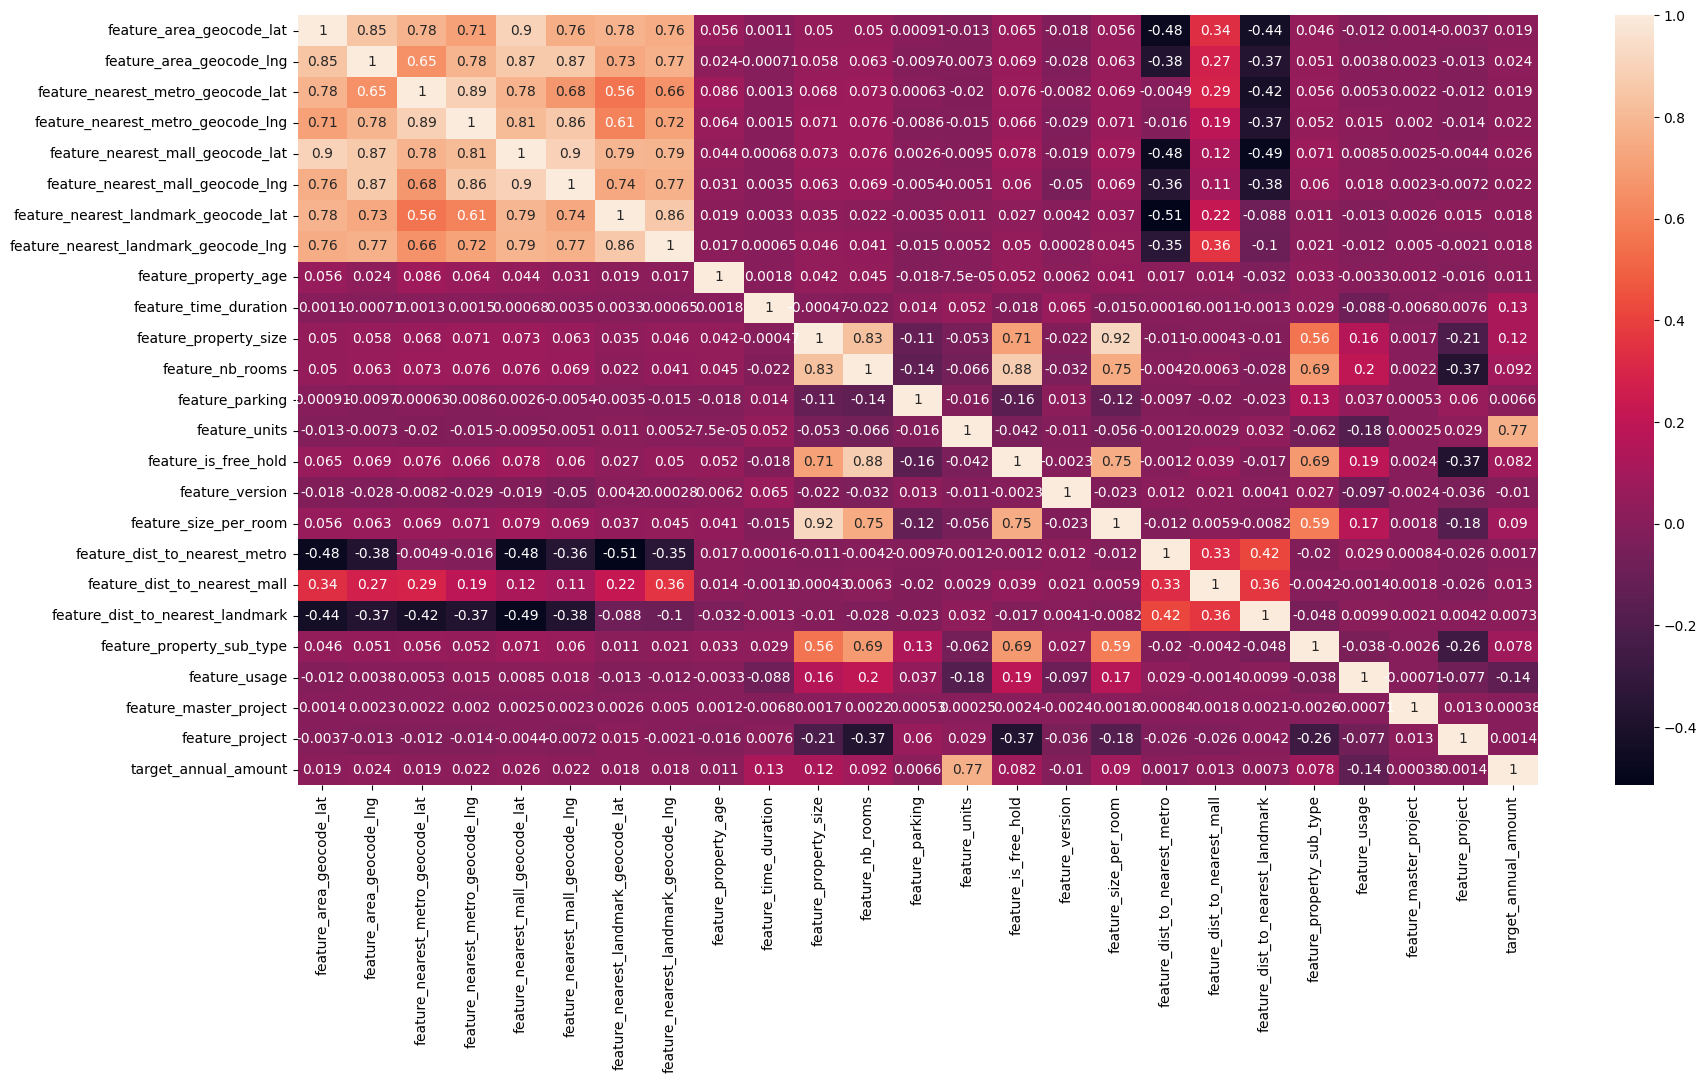

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix from your dataframe
corr = df_rents_to_train.corr()

plt.figure(figsize=(20, 10))
# Create a heatmap
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True)  # This will write the correlation values on the heatmap

plt.show()

Box-Cox transformation to transform non-normal dependent variables into a normal shape

In [82]:
from scipy import stats

# ensure all data is > 0
assert (df_rents_to_train['target_annual_amount'] > 0).all()

# perform the Box-Cox transformation
df_rents_to_train['target_annual_amount'], fitted_lambda = stats.boxcox(df_rents_to_train['target_annual_amount'])

# print the fitted lambda
print(f"The fitted lambda value is : {fitted_lambda}")


The fitted lambda value is : -0.23777992193035744


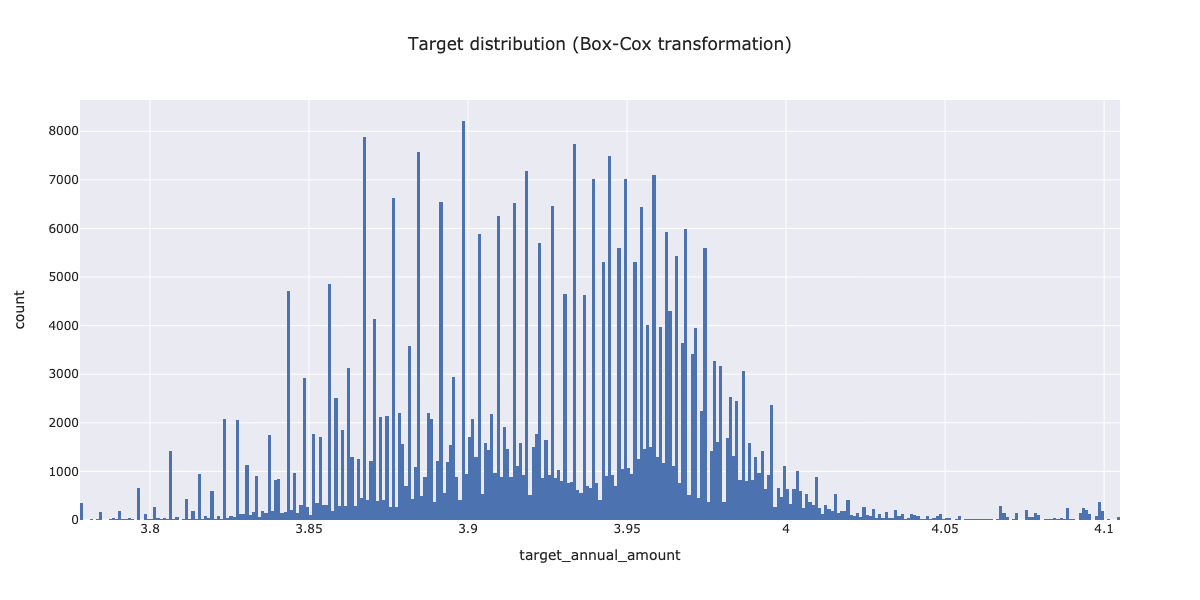

In [83]:
fig = px.histogram(df_rents_to_train, x="target_annual_amount", title="Target distribution (Box-Cox transformation)")
fig.update_layout(width=1200, height=600)
fig.show("png")

## Regression model to predict the correct rental price of a property according to its characteristics

In [84]:
X = df_rents_features # [[col for col in df_rents_to_train if col.startswith('feature_')]]
y = df_rents_to_train['target_annual_amount']

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [86]:
n_folds = 5

def rmsle_cv(model):
    X_train_model = X_train[[col for col in df_rents_to_train if col.startswith('feature_')]].values
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train_model)
    rmse = np.sqrt(-cross_val_score(model, X_train_model, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [87]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [88]:
score = rmsle_cv(model_lgb)
print("LightLGBM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] 

In [89]:
model_lgb.fit(X_train[[col for col in df_rents_to_train if col.startswith('feature_')]].values, y_train)
y_hat = model_lgb.predict(X_test[[col for col in df_rents_to_train if col.startswith('feature_')]].values)

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


In [90]:
X_test["Prediction Annual Amount"] = inv_boxcox(y_hat, fitted_lambda)

In [91]:
X_test["Price Diff"] = abs(X_test["Prediction Annual Amount"] -  X_test["Annual Amount"])

In [92]:
result = X_test[['Property ID', "Annual Amount", "Prediction Annual Amount", "Price Diff"]]

## Time Series model to predict to predict the rental price of a property x months ahead in the future
The target of this model is the percentage change of X months ahead. <br>
The approach here is to predict the rental price based on a property characteristics and then apply the percentage change to have the prediction in X months

In [93]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [94]:
df_rents_features["ejari_contract_number"] = df_rents["Ejari Contract Number"]

In [95]:
def predict_next_x_months(df_rents, x):
    df_rents_month = df_rents.groupby(pd.Grouper(key="Registration Date", freq="M")).agg({'Annual Amount':'mean','feature_property_size':'mean','feature_nb_rooms':'mean','feature_units':'mean', 'ejari_contract_number':'count', 'feature_time_duration':'mean'})
    df_rents_month["pct_amount_change"] = df_rents_month["Annual Amount"].pct_change(x)
    return df_rents_month.dropna()

In [96]:
df_months_sarima = predict_next_x_months(df_rents_features, 1)

In [97]:
exog_vars = df_months_sarima[["feature_property_size","feature_nb_rooms","feature_units","ejari_contract_number","feature_time_duration"]].values
sarima_train = df_months_sarima['pct_amount_change'].values

In [98]:
sarima = SARIMAX(sarima_train, exog=exog_vars, order=(4, 1, 1), seasonal_order=(1, 0, 1, 12))
sarima_model = sarima.fit(disp=False)

/Users/lucaordronneau/miniconda3/envs/general/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [99]:
sarima_pred = sarima_model.predict(start=len(sarima_train), end=len(sarima_train)+12, exog=exog_vars[-13:])
sarima_pred

array([ 0.09202254,  0.22668406,  0.01823563,  0.12613194,  0.45642748,
       -0.17177421,  0.28020169,  0.26178454,  0.15670285,  0.20919442,
        0.35334612,  0.56997932,  0.28643476])

In [100]:
for i, perc in enumerate(sarima_pred, start=1):
    result[f'{i} month forecast'] = result['Prediction Annual Amount'] * (1 + perc)

In [101]:
result

,Property ID,Annual Amount,Prediction Annual Amount,Price Diff,1 month forecast,2 month forecast,3 month forecast,4 month forecast,5 month forecast,6 month forecast,7 month forecast,8 month forecast,9 month forecast,10 month forecast,11 month forecast,12 month forecast,13 month forecast
3140515,611247888,737885.00,53080.715514,684804.284486,57965.338003,65113.267567,54048.676012,59775.889171,77308.212583,43962.817318,67954.021856,66976.426177,61398.614823,64184.905166,71836.580128,83335.625855,68284.877608
1009407,53439222,98530.33,124014.738008,25484.408008,135426.889714,152126.902207,126276.225373,139656.957575,180618.472008,102712.203837,158763.877527,156479.879078,143448.200680,149957.929561,167834.863898,194700.574529,159536.869923
3707878,30183,30000.00,51455.581599,21455.581599,56190.655130,63119.741699,52393.906749,57945.773961,74941.322895,42616.839504,65873.522666,64925.857329,59518.817795,62219.802299,69637.211458,80784.199209,66194.248848
4958936,619411980,40108.00,50656.056836,10548.056836,55317.556064,62138.977417,51579.802145,57045.403588,73776.873061,41954.652478,64849.969711,63917.029343,58594.005224,61253.021414,68555.177725,79528.961862,65165.712399
5203855,79338249,100000.00,164091.446253,64091.446253,179191.558615,201288.361353,167083.757800,184788.618805,238987.291092,135904.767016,210070.147264,207048.049933,189805.043257,198418.461662,222072.521308,257620.177844,211092.940541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5002710,670716,100000.00,192238.244301,92238.244301,209928.496629,235815.589832,195743.830552,216485.627111,279981.061162,159216.670946,246103.725771,242563.244543,222362.524728,232453.412884,260164.881098,301810.068812,247301.959977
1718231,301335,70000.00,142885.203551,72885.203551,156033.863507,175275.001477,145490.805819,160907.591558,208101.936533,118341.209990,182921.879460,180290.340753,165275.721923,172775.991255,193373.135132,224326.815265,183812.492766
4132484,324768,57900.00,44531.688961,13368.311039,48629.608275,54626.312973,45343.752539,50148.557307,64857.175407,36882.293082,57009.543590,56189.396645,51509.931459,53847.469935,60266.788254,69913.830926,57287.112672
2594144,833016,78750.00,125097.927209,46347.927209,136609.756742,153455.633134,127379.167216,140876.771533,182196.058525,103609.329065,160150.578177,157846.630466,144701.128715,151267.715903,169300.793796,196401.159180,160930.322166


### Impacting factors on rents over time

Feature importances for year 2016:
                                 feature  importance
20             feature_property_sub_type    0.404087
13                         feature_units    0.191062
10                 feature_property_size    0.092750
11                      feature_nb_rooms    0.087900
21                         feature_usage    0.028409
23                       feature_project    0.022852
14                  feature_is_free_hold    0.022575
15                       feature_version    0.015768
4       feature_nearest_mall_geocode_lat    0.014077
3      feature_nearest_metro_geocode_lng    0.014039
12                       feature_parking    0.013488
19      feature_dist_to_nearest_landmark    0.011573
17         feature_dist_to_nearest_metro    0.011375
9                  feature_time_duration    0.011290
6   feature_nearest_landmark_geocode_lat    0.010430
7   feature_nearest_landmark_geocode_lng    0.008182
2      feature_nearest_metro_geocode_lat    0.007648
18         

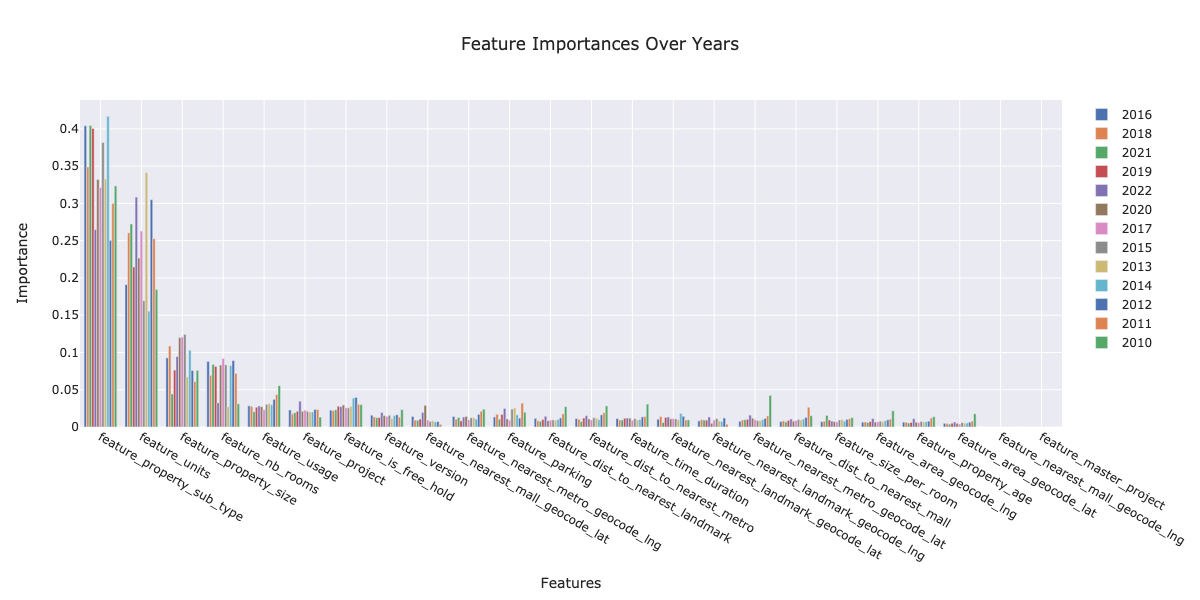

In [102]:
df_rents_features_tmp = df_rents_features.copy(deep=True)
df_rents_features_tmp["Year"] = df_rents_features_tmp["Registration Date"].dt.year
df_rents_features_tmp["target"] = df_rents_to_train["target_annual_amount"]
years = df_rents_features_tmp['Year'].unique()

fig = go.Figure()

for year in years:
    df_year = df_rents_features_tmp[df_rents_features_tmp['Year'] == year]
    X = df_year[[col for col in df_rents_to_train if col.startswith('feature_')]]
    y = df_year["target"]
    
    xgb_model = xgb.XGBRegressor(objective ='reg:squarederror')
    xgb_model.fit(X, y)
    importances = xgb_model.feature_importances_
    
    feature_importance = pd.DataFrame({'feature': X.columns, 'importance': importances})
    feature_importance = feature_importance.sort_values('importance', ascending=False)

    fig.add_trace(go.Bar(x=feature_importance['feature'], 
                        y=feature_importance['importance'], 
                        name=str(year)))

    print(f"Feature importances for year {year}:")
    print(feature_importance)
    print("\n")
    
fig.update_layout(barmode='group', 
                  xaxis_title='Features', 
                  yaxis_title='Importance', 
                  title='Feature Importances Over Years')
fig.update_layout(width=1200, height=600)
fig.show("png")
